# CODEX analyses

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib import Path
from time import time
import copy
from skimage import color
import matplotlib as mpl
import napari
import colorcet as cc

from sklearn.preprocessing import StandardScaler
import umap
# if not installed run: conda install -c conda-forge umap-learn
import hdbscan
from sklearn.cluster import OPTICS, cluster_optics_dbscan

from skimage import io

from scipy.stats import ttest_ind    # Welch's t-test
from scipy.stats import mannwhitneyu # Mann-Whitney rank test
from scipy.stats import ks_2samp     # Kolmogorov-Smirnov statistic

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

/home/alexis/.pyenv/versions/3.8.10/envs/spatial-networks/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

In [3]:
data_dir = Path("../data/raw/CODEX_CTCL")
objects_path = data_dir / "41467_2021_26974_MOESM3_ESM_-_Objects.xlsx"

In [4]:
RUN_LONG = False

### Objects data

File that contains all the detected objects (the cells) across all samples.

In [5]:
obj = pd.read_excel(objects_path, skiprows=2)
obj

Count  EventCount  Index in File  ClusterID FileName  ClusterName  \
0            0           1             60      33987   reg001      B cells   
1            1           1             94      33987   reg001      B cells   
2            2           1            198      33987   reg001      B cells   
3            3           1            284      33987   reg001      B cells   
4            4           1            298      33987   reg001      B cells   
...        ...         ...            ...        ...      ...          ...   
117165  116917           1            633      33981   reg066  vasculature   
117166  116918           1            677      33981   reg066  vasculature   
117167  116919           1            681      33981   reg066  vasculature   
117168  116920           1            705      33981   reg066  vasculature   
117169  116921           1            711      33981   reg066  vasculature   

        Spots  Patients  Groups      FOXP3  ...  PD-1+CD8+  CD4+Tcells  \
0           1         1       1   0.692403  ...          0           0   
1           1         1       1   8.094747  ...          0           0   
2           1         1       1   4.110389  ...          0           0   
3           1         1       1   0.000000  ...          0           0   
4           1         1       1   2.937673  ...          0           0   
...       ...       ...     ...        ...  ...        ...         ...   
117165     66        14       4  84.269714  ...          0           0   
117166     66        14       4  56.425945  ...          0           0   
117167     66        14       4  63.152092  ...          0           0   
117168     66        14       4  66.873306  ...          0           0   
117169     66        14       4  17.966373  ...          0           0   

        PD-1+tumor  CD8+Tcells  Ki67+CD4+  Ki-67+Tregs  ICOS+Tregs  IDO+Tregs  \
0                0           0          0            0           0          0   
1                0           0          0            0           0          0   
2                0           0          0            0           0          0   
3                0           0          0            0           0          0   
4                0           0          0            0           0          0   
...            ...         ...        ...          ...         ...        ...   
117165           0           0          0            0           0          0   
117166           0           0          0            0           0          0   
117167           0           0          0            0           0          0   
117168           0           0          0            0           0          0   
117169           0           0          0            0           0          0   

        Ki67+tumor  original_index  
0                0               0  
1                0               1  
2                0               2  
3                0               3  
4                0               4  
...            ...             ...  
117165           0          116917  
117166           0          116918  
117167           0          116919  
117168           0          116920  
117169           0          116921  

[117170 rows x 121 columns]

In [6]:
# sample_cols = obj.columns[:10]
obj.rename(columns={'X': 'x', 'Y': 'y', 'Z':'z'}, inplace=True)
sample_cols = ['FileName', 'ClusterName', 'Patients', 'Spots' ,'Groups']
marker_cols = obj.columns[9:67]
marker_cols = [x for x in marker_cols if x != 'HOECHST1:Cyc_1_ch_1']
# cell_pos_cols = obj.columns[69:76]
cell_pos_cols = ['x', 'y', 'z']#	size]
# cell_type_cols = obj.columns[76:101]
cell_type_cols = list(obj.columns[75:96])
marker_posit_cols = list(obj.columns[100:-1])
all_cols = sample_cols + marker_cols + cell_pos_cols + cell_type_cols + marker_posit_cols
nb_clusters = obj['ClusterName'].unique().size

In [7]:
obj.shape

(117170, 121)

In [8]:
obj[['FileName', 'Patients', 'Count']].groupby(['Patients', 'FileName']).count()

Count
Patients FileName       
1        reg001     1301
         reg002     2324
         reg003     1145
         reg004      745
2        reg005      112
...                  ...
14       reg062     3696
         reg063     3610
         reg064     4163
         reg065     1238
         reg066      792

[69 rows x 1 columns]

### Response status pre/post treatment

In [9]:
code_groups = {
  1: 'Responder, pre-treatment',
  2: 'Non-responder, pre-treatment',
  3: 'Responder, post-treatment',
  4: 'Non-responder, post-treatment',
} 

In [10]:
status_path = data_dir / "41467_2021_26974_MOESM5_ESM - Patients_spots_conditons.xlsx"
status = pd.read_excel(status_path, skiprows=2, usecols=['Patients', 'Groups', 'Spots'])
# samples 25, 36, 37, 40, 44 are missing
# 36 and 37 should be patient 9
# 40 is either 10 or 11
# 44 is 11, which make 4 samples of this patient
# so probably 40 is patient 10

# /!\ this is a guess that makes sense, but it still might be wrong /!\
guessed_data = [[9, 1, 36],
                [9, 3, 37],
                [10, 3, 40],
                [11, 3, 44]]
status = pd.concat([status, pd.DataFrame(guessed_data, columns=status.columns)], axis=0)

status['FileName'] = status['Spots'].apply(lambda x: f'reg{x:03}')
# pd.set_option('display.max_rows', 100)
status.sort_values('Spots')

Patients  Groups  Spots FileName
28         1       1      1   reg001
29         1       1      2   reg002
26         1       3      3   reg003
27         1       3      4   reg004
32         2       1      6   reg006
..       ...     ...    ...      ...
23        14       4     66   reg066
61         9       3     67   reg067
62         9       3     68   reg068
12        13       3     69   reg069
13        13       3     70   reg070

[68 rows x 4 columns]

### Survival data

In [11]:
survival_path = data_dir / "cohort_response.ods"
surv = pd.read_excel(survival_path)
surv.index = surv['Patient ID']
surv.drop(columns=['Patient ID'], inplace=True)
# surv.index.name = 'sample'
surv

Age at screening (years)  Gender Diagnosis Disease Stage  \
Patient ID                                                             
1                              76.14    Male        MF          IIIA   
2                              60.59    Male        MF          IIIB   
3                              52.01    Male        SS           IVA   
4                              85.14  Female        SS           IVA   
5                              75.24    Male        MF           IIB   
6                              46.74    Male        MF           IVA   
7                              46.71  Female        MF          IIIB   
8                              67.44    Male        SS          IIIB   
9                              77.65  Female        SS           IVA   
10                             66.40    Male        MF          IIIA   
11                             72.23    Male        SS           IVA   
12                             72.59    Male        SS           IVA   
13                             44.10  Female        SS           IVA   
14                             63.69    Male        MF            IB   

            Prior therapies Response status        Biopsy timepoints  \
Patient ID                                                             
1                         3       Responder                 Pre, EOT   
2                         4       Responder                 Pre, EOT   
3                         3   Non-responder                 Pre, EOT   
4                         4   Non-responder                 Pre, EOT   
5                         6       Responder                 Pre, EOT   
6                         9   Non-responder            Pre, CO2, EOT   
7                         3   Non-responder                 Pre, EOT   
8                         1   Non-responder                 Pre, EOT   
9                         6       Responder            Pre, CO2, EOT   
10                        2       Responder                      Pre   
11                        3       Responder            Pre, Response   
12                        5   Non-responder         Pre, Progression   
13                        1       Responder  Pre, CO2, Response, EOT   
14                        5   Non-responder  Pre, CO2, Response, EOT   

            CO2 (weeks)  Response / progression time (weeks)  \
Patient ID                                                     
1                   NaN                                  NaN   
2                   NaN                                  NaN   
3                   NaN                                  NaN   
4                   NaN                                  NaN   
5                   NaN                                  NaN   
6                   3.0                                  NaN   
7                   NaN                                  NaN   
8                   NaN                                  NaN   
9                   3.0                                  NaN   
10                  NaN                                  NaN   
11                  NaN                                 22.0   
12                  NaN                                 15.0   
13                  3.0                                 15.0   
14                  3.0                                 10.0   

            EOT time (weeks)  Death time (weeks)  Follow-up time (weeks)  
Patient ID                                                                
1                      104.0                 NaN                     142  
2                      104.0                 NaN                     151  
3                       98.0                98.0                      98  
4                      104.0               142.0                     142  
5                      104.0                 NaN                     103  
6                       25.0                 NaN                      25  
7                        9.0                 NaN                       9  
8     

## Spatial networks reconstruction

### Load samples of one patient

We will have a look at the spatial networks of the 4 samples of the first patient to check they seem "correct", i.e. not over nor under connected.

processing filename reg001
all nodes have at least one edge
processing filename reg002
there are 1/2324 nodes with no edges
processing filename reg003
there are 1/1145 nodes with no edges
processing filename reg004
all nodes have at least one edge


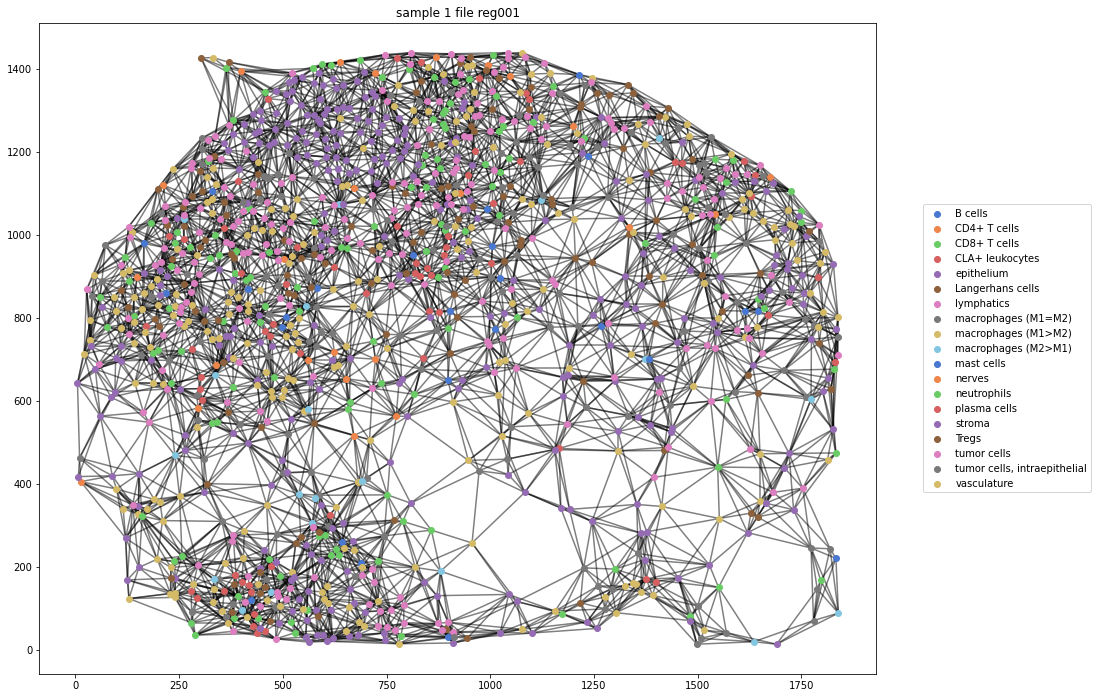

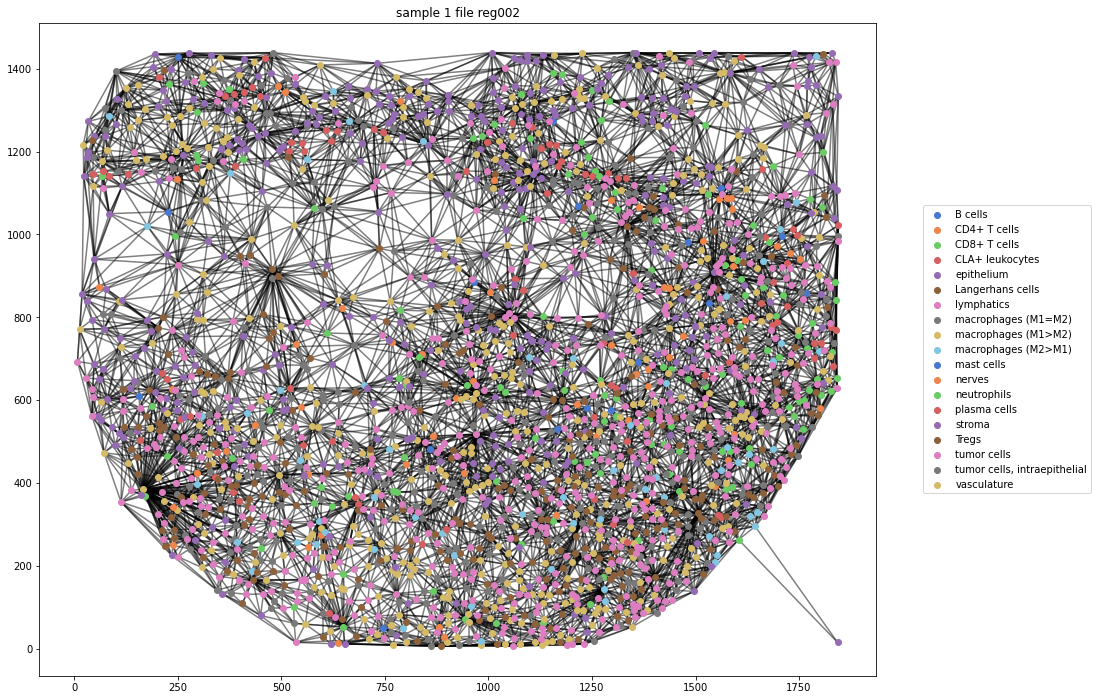

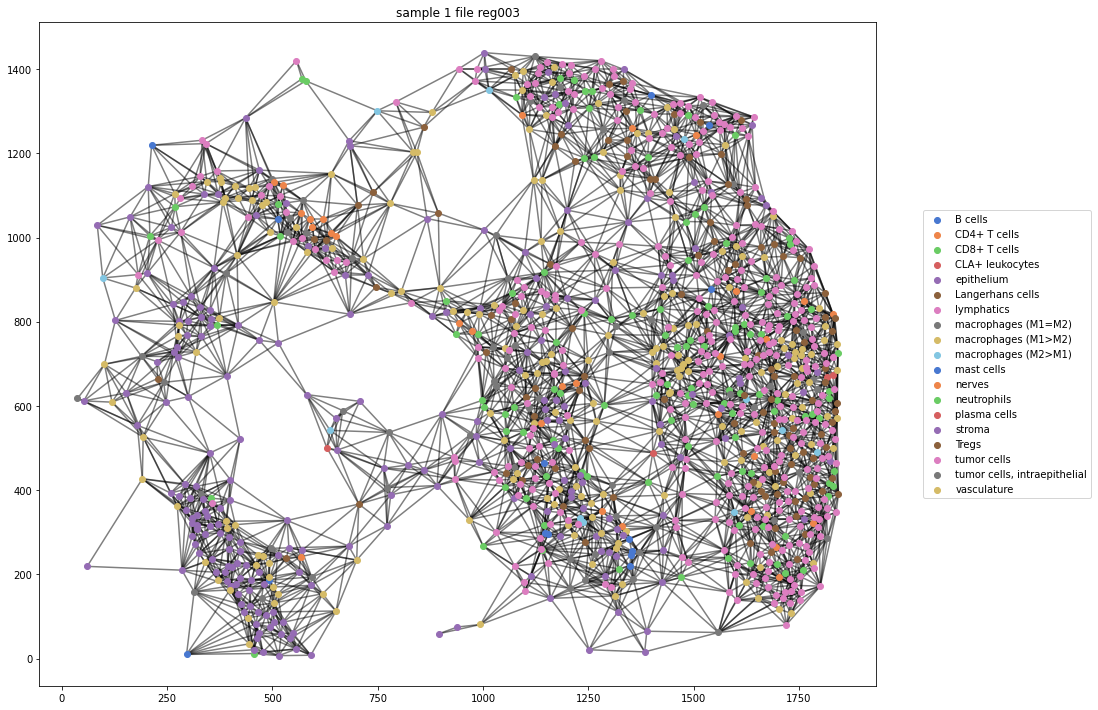

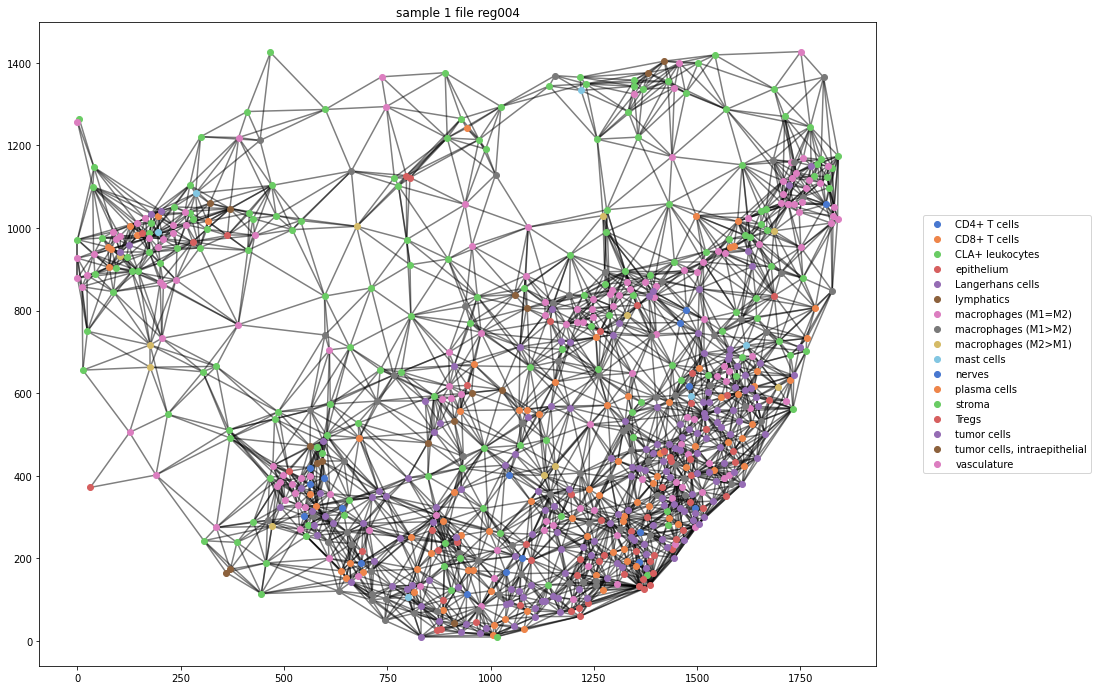

In [12]:
sample_id = 1  # that's our patient
select_sample = obj['Patients'] == sample_id
filenames = obj.loc[select_sample, 'FileName'].unique()  # look for the several samples per patient
for filename in filenames:
    print("processing filename {}".format(filename))
    select_file = obj['FileName'] == filename
    nodes = obj.loc[select_sample & select_file, all_cols]
    coords = nodes[['x', 'y', 'z']].values
    pairs = ty.build_delaunay(coords)
    # we want to avoid isolated cells, so we link them to their 2 closest neighbors
    pairs = ty.link_solitaries(coords, pairs, method='knn', k=2)

    fig, ax = ty.plot_network(coords[:, :-1], pairs, labels=nodes['ClusterName'],
                              legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
    plt.title("sample {} file {}".format(sample_id, filename))

### All samples network reconstruction

#### Plot spatial networks

In [147]:
processed_dir = Path('../data/processed/CODEX_CTCL')
save_dir = processed_dir / "all_samples_networks"

In [14]:
k_sol = 2  # link isolated nodes to 2 closest neighbors

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[['x', 'y', 'z']].values
            pairs = ty.build_delaunay(coords)
            print("    ", end="")
            pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            fig, ax = ty.plot_network(coords[:, :-1], pairs, labels=nodes['ClusterName'],
                                    legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
            plt.axis('off');
            title = f"sample-{sample_id}_filename-{filename}_network_delaunay"
            plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
            plt.show()

#### Merge all samples

In [15]:
if RUN_LONG:
    edges_all = pd.DataFrame(data=None, columns=['source', 'target'])
    # number of nodes previously seen
    nb_nodes = 0
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[['x', 'y', 'z']].values
            pairs = ty.build_delaunay(coords)
            print("    ", end="")
            pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            # increase ids in pairs by the number of nodes in all previously loaded networks
            pairs = pairs + nb_nodes
            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            # update number of nodes for next network
            nb_nodes = nb_nodes + coords.shape[0]
            edges_all = pd.concat([edges_all, edges], ignore_index=True)
    edges_all.to_csv(save_dir / 'sample_all-edges.csv', index=False)
else:
    edges_all = pd.read_csv(save_dir / 'sample_all-edges.csv')

In [ ]:
# or save in separate file for convenience
if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[['x', 'y', 'z']].values
            pairs = ty.build_delaunay(coords)
            print("    ", end="")
            pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            edges.to_csv(save_dir / f'edges_sample-{filename}.csv', index=False)

## Response groups characteristics and survival analysis

We will look at what variables define or explain response to therapy or longer survival.  
For this, we will start with the simplest statistics, like proportions of cell types or marker-positive cells, and we will gradulally increase the complexity of variables, looking at interactions between cell types and finally discovering spatial neighborhoods, potentially predictive of response to therapy.

### Cell types proportions

In [16]:
# we add attributes to nodes to color network figures
nodes_all = obj[['x', 'y', 'z']].copy()
nodes_all['CellCluster'] = obj['ClusterName'].values
nodes_all = nodes_all.join(pd.get_dummies(obj['ClusterName']))
attribute_uniq = nodes_all['CellCluster'].unique()

In [17]:
# here we don't use `FileName` in the group / unstack procedure to aggregate statistics 
# per patient and condition (before / after treatment) rather than per sample.

count_types = obj[['Patients', 'Groups', 'Count']].join(nodes_all['CellCluster']).groupby(['Patients', 'Groups', 'CellCluster']).count().unstack()
count_types.columns = count_types.columns.droplevel()
count_types = count_types.fillna(value=0).astype(int)
# count_types.index.name = 'sample'
count_types.to_csv(save_dir / 'count_types_per_patient_per_condition.csv')
count_types.head(6)

CellCluster      B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                         
1        1            34            50           229               20   
         3             3            23           191                7   
2        1             6             3             5                3   
         3            79            29            18                0   
3        2             2           208           186               14   
         4             0            63           192                8   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells  Tregs  \
Patients Groups                                                             
1        1                 0                   0                42    350   
         3                 0                   0                15    160   
2        1                 0                   0                12     15   
         3                 0                   0                13     76   
3        2                 0                   2               130     99   
         4                 0                   8                63    157   

CellCluster      epithelium  lymphatics  ...  macrophages (M1>M2)  \
Patients Groups                          ...                        
1        1              112          23  ...                  545   
         3               72          30  ...                  201   
2        1                6           5  ...                   71   
         3              259           0  ...                  265   
3        2             1759          24  ...                  397   
         4             2299           0  ...                  295   

CellCluster      macrophages (M2>M1)  mast cells  nerves  neutrophils  \
Patients Groups                                                         
1        1                        83           9      33           36   
         3                        22          17      24            2   
2        1                        64           3       6            1   
         3                       146          11      12            0   
3        2                        39          33      17            0   
         4                        43           8       6            0   

CellCluster      plasma cells  stroma  tumor cells  \
Patients Groups                                      
1        1                133     582          777   
         3                  4     317          527   
2        1                  4     203          155   
         3                 12     396         2900   
3        2                  4     328          546   
         4                  1     278          428   

CellCluster      tumor cells, intraepithelial  vasculature  
Patients Groups                                             
1        1                                 48          149  
         3                                  3          143  
2        1                                  2           95  
         3                                  0          166  
3        2                                274           86  
         4                                320          111  

[6 rows x 21 columns]

Instead of counts we use proportions of cell types per patient and condition.

In [18]:
prop_types = count_types.div(count_types.sum(axis=1), axis=0)
prop_types

CellCluster       B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
         3       0.001587      0.012169      0.101058         0.003704   
2        1       0.008392      0.004196      0.006993         0.004196   
         3       0.016982      0.006234      0.003869         0.000000   
3        2       0.000465      0.048327      0.043216         0.003253   
         4       0.000000      0.014041      0.042790         0.001783   
4        2       0.058649      0.006590      0.014827         0.000000   
         4       0.004557      0.013671      0.074623         0.000570   
5        1       0.000000      0.000000      0.000984         0.000000   
         3       0.000929      0.013928      0.005571         0.002786   
6        2       0.017263      0.041597      0.144135         0.003120   
         4       0.013105      0.008403      0.056923         0.001401   
7        2       0.000000      0.000000      0.000000         0.000000   
         4       0.004601      0.003067      0.013804         0.000000   
8        2       0.004871      0.008524      0.007916         0.002841   
         4       0.008799      0.004969      0.048551         0.003209   
9        1       0.000749      0.007113      0.019094         0.000749   
         3       0.005252      0.041900      0.079026         0.001910   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
         3       0.004415      0.002208      0.006623         0.002208   
12       2       0.005878      0.018001      0.039309         0.001837   
         4       0.002824      0.016590      0.022238         0.001765   
13       1       0.001793      0.013625      0.005737         0.002510   
         3       0.081141      0.014507      0.042660         0.001967   
14       2       0.004636      0.014238      0.034437         0.002318   
         4       0.034213      0.005217      0.042253         0.001197   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
         3          0.000000            0.000000          0.007937  0.084656   
2        1          0.000000            0.000000          0.016783  0.020979   
         3          0.000000            0.000000          0.002794  0.016337   
3        2          0.000000            0.000465          0.030204  0.023002   
         4          0.000000            0.001783          0.014041  0.034990   
4        2          0.000000            0.000000          0.005272  0.002965   
         4          0.000570            0.000000          0.001709  0.057818   
5        1          0.000000            0.000000          0.004921  0.005906   
         3          0.000000            0.000000          0.011142  0.047354   
6        2          0.000000            0.000624          0.019759  0.074251   
         4          0.000000            0.000100          0.026511  0.105342   
7        2          0.000000            0.000000          0.002494  0.000000   
         4          0.000000            0.000000          0.004601  0.015337   
8        2          0.000000            0.000000          0.001827  0.007713   
         4          0.018116            0.001035          0.003520  0.010973   
9        1          0.000000            0.000000          0.004118  0.003370   
         3          0.000477            0.015280          0.000955  0.010386   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
         3          0.000000            0.000000          0.000000  0.019868   
12       2   

#### Descriptive statistics

In [56]:
pvals = mosna.find_DE_markers(prop_types, group_ref=1, group_tgt=2, group_var='Groups', composed_vars=False)
pvals = pvals.sort_values(by='pval', ascending=True)
pvals

pval  pval_corr
CellCluster                                      
macrophages (M1=M2)           0.212121   0.999961
CD4+ T cells                  0.212121   0.999961
tumor cells                   0.575175   0.999961
macrophages (M2>M1)           0.575175   0.999961
lymphatics                    0.575175   0.999961
Langerhans cells              0.575175   0.999961
B cells                       0.575175   0.999961
CD8+ T cells                  0.575175   0.999961
IDO+ stromal cells            0.575175   0.999961
vasculature                   0.575175   0.999961
Tregs                         0.962704   0.999961
epithelium                    0.962704   0.999961
tumor cells, intraepithelial  0.962704   0.999961
macrophages (M1>M2)           0.962704   0.999961
CLA+ leukocytes               0.962704   0.999961
nerves                        0.962704   0.999961
neutrophils                   0.962704   0.999961
stroma                        0.962704   0.999961
DCs, CD11c+                   0.999961   0.999961
mast cells                    0.999961   0.999961
plasma cells                  0.999961   0.999961

Cell types proportions are not significantly associated with response / non response in samples before treatment.  
But `mosna` can find composed variables potentially related to response of patients:

In [57]:
# `find_DE_markers` can make composite variables, but we do it beforehand to reuse them
prop_types_comp = pd.concat([prop_types, mosna.make_composed_variables(prop_types, order=2)], axis=1)

pvals = mosna.find_DE_markers(prop_types_comp, group_ref=1, group_tgt=2, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [58]:
pvals.head(20)

pval  pval_corr
((lymphatics / macrophages (M1=M2)) / (macropha...  0.000583        1.0
((CD8+ T cells / nerves) / (Tregs / tumor cells))   0.008159        1.0
((lymphatics / macrophages (M1>M2)) / (stroma /...  0.008159        1.0
((lymphatics / tumor cells) / (macrophages (M1=...  0.008159        1.0
(lymphatics / macrophages (M1=M2))                  0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((lymphatics / stroma) / (stroma / tumor cells))    0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((macrophages (M1=M2) / macrophages (M1>M2)) / ...  0.008159        1.0
((B cells / macrophages (M2>M1)) / (nerves / tu...  0.008159        1.0
((lymphatics / stroma) / (nerves / tumor cells))    0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (mast cel...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M2>M1) /...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M1>M2) /...  0.008159        1.0
((CD4+ T cells / stroma) / (Tregs / lymphatics))    0.008159        1.0
((epithelium / nerves) / (epithelium / tumor ce...  0.008159        1.0
((macrophages (M1>M2) / vasculature) / (macroph...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M1=M2) /...  0.008159        1.0
((CD4+ T cells / nerves) / (mast cells / tumor ...  0.008159        1.0

The first variables related to cell types proportions are composed variables of the 2nd order (ratio of ratios), only `lymphatics / macrophages (M1=M2)` appear in the simpler composed variables, but all corrected pvalues are > 0.05. This is because mosna produced *a lot* of composed variables.

#### Visualization

In [22]:
prop_types_comp

B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
         3       0.001587      0.012169      0.101058         0.003704   
2        1       0.008392      0.004196      0.006993         0.004196   
         3       0.016982      0.006234      0.003869         0.000000   
3        2       0.000465      0.048327      0.043216         0.003253   
         4       0.000000      0.014041      0.042790         0.001783   
4        2       0.058649      0.006590      0.014827         0.000000   
         4       0.004557      0.013671      0.074623         0.000570   
5        1       0.000000      0.000000      0.000984         0.000000   
         3       0.000929      0.013928      0.005571         0.002786   
6        2       0.017263      0.041597      0.144135         0.003120   
         4       0.013105      0.008403      0.056923         0.001401   
7        2       0.000000      0.000000      0.000000         0.000000   
         4       0.004601      0.003067      0.013804         0.000000   
8        2       0.004871      0.008524      0.007916         0.002841   
         4       0.008799      0.004969      0.048551         0.003209   
9        1       0.000749      0.007113      0.019094         0.000749   
         3       0.005252      0.041900      0.079026         0.001910   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
         3       0.004415      0.002208      0.006623         0.002208   
12       2       0.005878      0.018001      0.039309         0.001837   
         4       0.002824      0.016590      0.022238         0.001765   
13       1       0.001793      0.013625      0.005737         0.002510   
         3       0.081141      0.014507      0.042660         0.001967   
14       2       0.004636      0.014238      0.034437         0.002318   
         4       0.034213      0.005217      0.042253         0.001197   

                 DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
         3          0.000000            0.000000          0.007937  0.084656   
2        1          0.000000            0.000000          0.016783  0.020979   
         3          0.000000            0.000000          0.002794  0.016337   
3        2          0.000000            0.000465          0.030204  0.023002   
         4          0.000000            0.001783          0.014041  0.034990   
4        2          0.000000            0.000000          0.005272  0.002965   
         4          0.000570            0.000000          0.001709  0.057818   
5        1          0.000000            0.000000          0.004921  0.005906   
         3          0.000000            0.000000          0.011142  0.047354   
6        2          0.000000            0.000624          0.019759  0.074251   
         4          0.000000            0.000100          0.026511  0.105342   
7        2          0.000000            0.000000          0.002494  0.000000   
         4          0.000000            0.000000          0.004601  0.015337   
8        2          0.000000            0.000000          0.001827  0.007713   
         4          0.018116            0.001035          0.003520  0.010973   
9        1          0.000000            0.000000          0.004118  0.003370   
         3          0.000477            0.015280          0.000955  0.010386   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
         3          0.000000            0.000000          0.000000  0.019868   
12       2          0.000000   

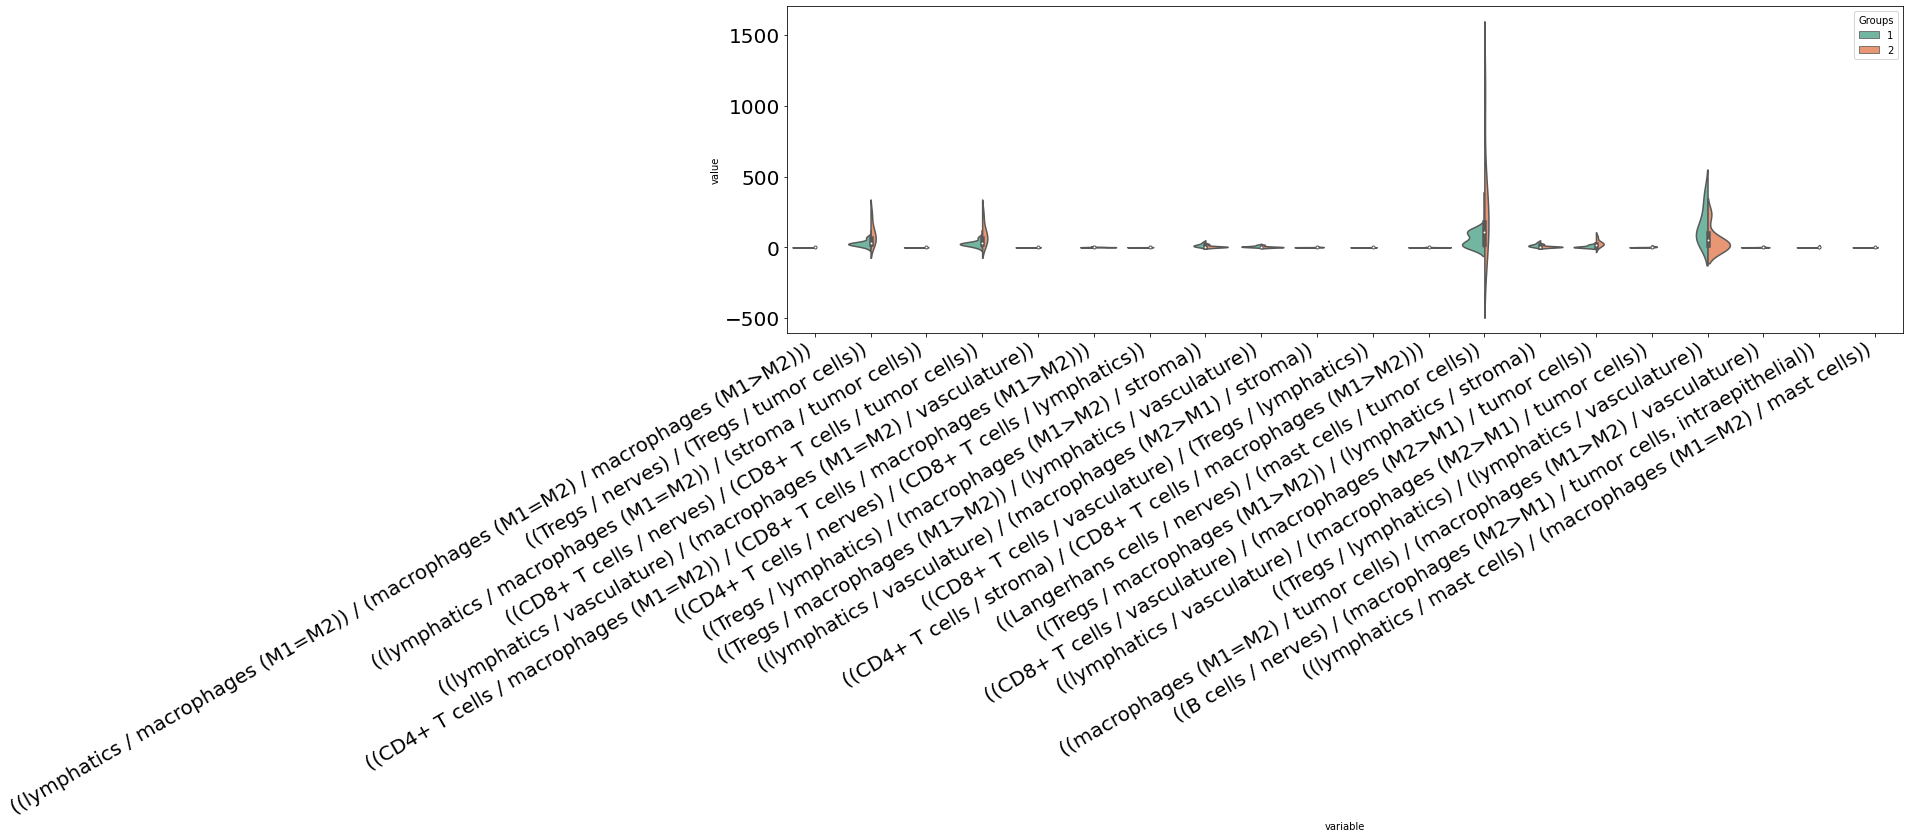

In [23]:
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

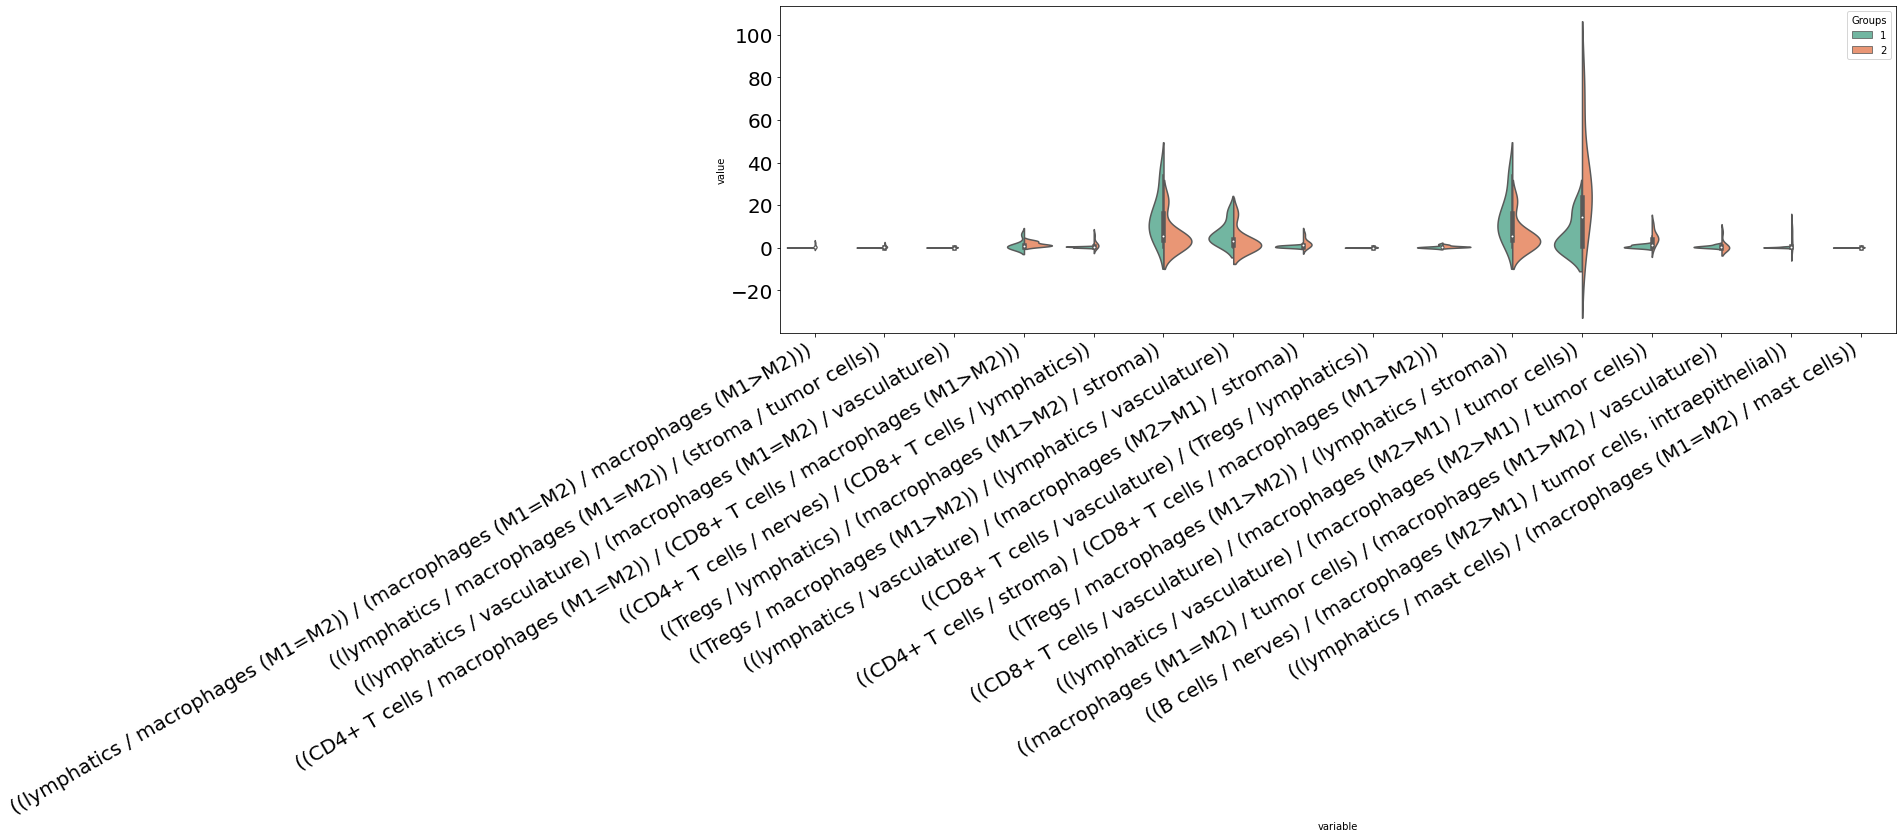

In [24]:
exclude_vars = [
    '((Langerhans cells / nerves) / (mast cells / tumor cells))',
    '((Tregs / lymphatics) / (lymphatics / vasculature))',
    '((Tregs / nerves) / (Tregs / tumor cells))',
    '((CD8+ T cells / nerves) / (CD8+ T cells / tumor cells))',
]
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    exclude_vars=exclude_vars,
    )

### Heatmap of cell types proportions

/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


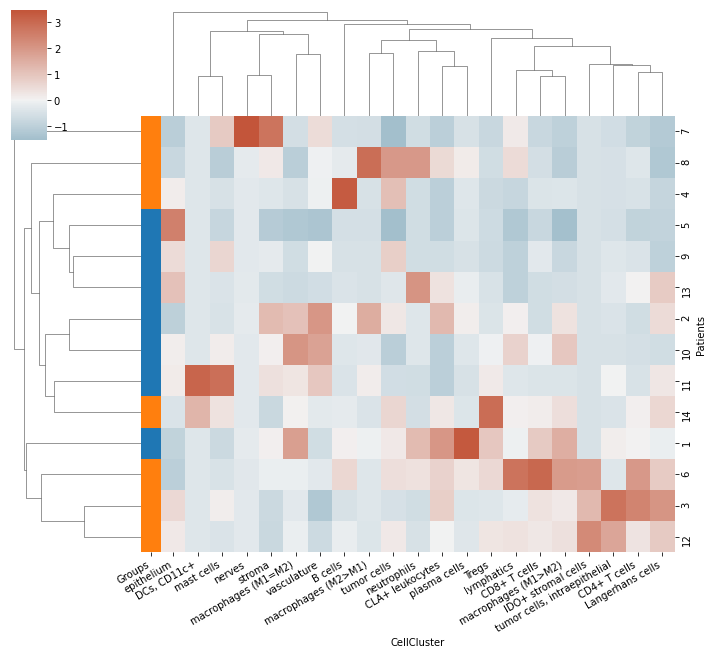

In [25]:
g = mosna.plot_heatmap(prop_types.reset_index(), obs_labels='Patients', group_var='Groups', groups=[1, 2])

There is no clear separation of patients into their respective groups from their proportions of cell types scaled across patients.

In [59]:
# we need to clean-up data for further analyses and visualizations
prop_types_comp_cleaned, select_finite = mosna.clean_data(
    prop_types_comp, 
    method='mixed',
    thresh=0.9,
    )

There are 131834 non finite values
Imputing data


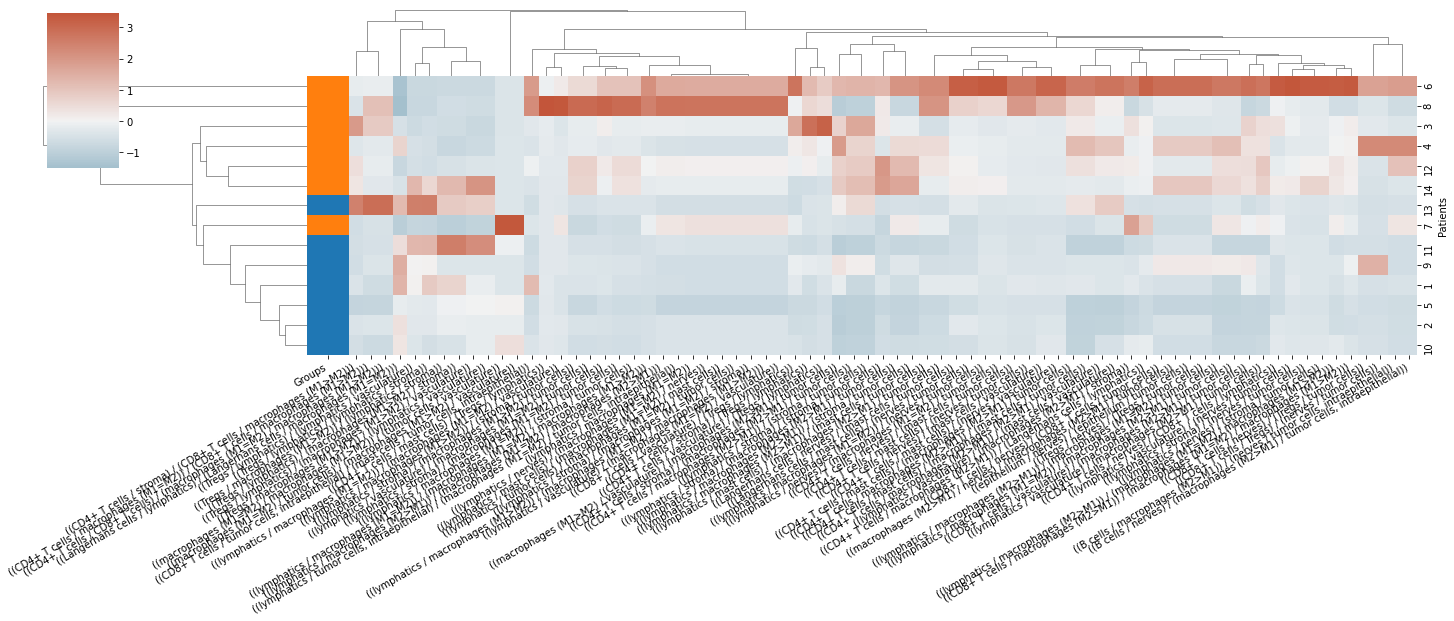

In [60]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index
# or to select only 20 variables:
# best_pval_names = pvals.head(20).index
mosna.plot_heatmap(
    prop_types_comp_cleaned[best_pval_names].reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    )

By selecting the variables with p-values under 5%, although their corresponding corrected p-values are not significant, we can notice a much better separation between patients groups.

#### Stepwise logistic regression

In [28]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
model, included = mosna.stepwise_regression(X=prop_types_comp_cleaned, y_name='Groups', y_values=[1, 2], col_names=best_pval_names, verbose=True)

Add  ((Langerhans cells / lymphatics) / (Langerhans cells / macrophages (M1=M2))) with p-value 0.00186317
Add  ((macrophages (M1>M2) / vasculature) / (macrophages (M2>M1) / tumor cells)) with p-value 0.000234876
Add  ((CD8+ T cells / macrophages (M2>M1)) / (macrophages (M1=M2) / macrophages (M1>M2))) with p-value 0.00216709


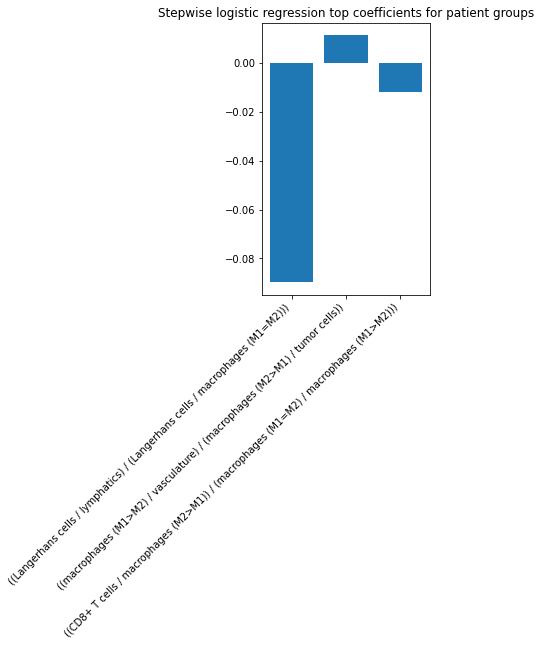

In [29]:
# plot the model's coefficients
coefs = model.params[1:] # skip intercept
nb_coefs = min(coefs.size, 20)
if nb_coefs > 0:
    fig, ax = plt.subplots(figsize=(nb_coefs,5))
    ax.bar(coefs.index, coefs)
    plt.xticks(rotation=45, ha='right');
    title = f"Stepwise logistic regression top coefficients for patient groups"
    plt.title(title)

#### Risk ratios

#### Survival analysis

### Marker-positive cells proportions

In [30]:
def highlight_under(s, thresh=0.05, color='darkorange'):
    '''
    highlight values that are under a threshold
    '''
    is_under = s <= thresh
    attr = 'background-color: {}'.format(color)
    return [attr if v else '' for v in is_under]

We have seen that cell types proportions don't explain response of patient to therapy. But maybe interactions between cell types play a role in response?  
To answer this question we will look at the *mixing matrix* and *assortativity* of tissue networks.  

## Cell types interactions

We compute cell types interactions per sample to aggregate latter per patient or condition.

###  Assortativity and Mixing Matrix

#### Computation of assortativity

In [31]:
grouping = 'FileName'
n_shuffle = 500
save_dir = processed_dir / "assortativity"
filename = f'network_interactions_stats_grouping-{grouping}_n_shuffle-{n_shuffle}.csv'

if RUN_LONG:
    start = time()
    net_stats = mosna.batch_assort_mixmat(nodes_all, edges_all, 
                                    attributes=attribute_uniq, 
                                    groups=obj[grouping], 
                                    n_shuffle=n_shuffle,
                                    parallel='max',
                                    memory_limit='100GB')
    end = time()
    duration = end - start
    print(f"Assortativity took {duration}s for n_suffle {n_shuffle}")

    net_stats.index = net_stats['id']
    net_stats.drop(columns=['id'], inplace=True)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    net_stats.to_csv(save_dir / filename)
else:
    net_stats = pd.read_csv(save_dir / filename, index_col=0)

In [32]:
net_stats

# total  % B cells  % CD4+ T cells  % CD8+ T cells  % CLA+ leukocytes  \
id                                                                              
reg001     1301   0.017679        0.012298        0.082244           0.009224   
reg002     2324   0.004733        0.014630        0.052496           0.003442   
reg006      603   0.009950        0.004975        0.008292           0.004975   
reg035     2053   0.000487        0.007306        0.014613           0.000974   
reg036      618   0.001618        0.006472        0.033981           0.000000   
...         ...        ...             ...             ...                ...   
reg005      112   0.000000        0.000000        0.000000           0.000000   
reg018      458   0.000000        0.000000        0.000000           0.000000   
reg027      249   0.000000        0.004016        0.000000           0.000000   
reg026      257   0.000000        0.000000        0.000000           0.000000   
reg025      144   0.000000        0.000000        0.000000           0.000000   

        % DCs, CD11c+  % epithelium  % IDO+ stromal cells  % Langerhans cells  \
id                                                                              
reg001            0.0      0.069178                   0.0            0.016910   
reg002            0.0      0.009466                   0.0            0.008606   
reg006            0.0      0.006633                   0.0            0.019900   
reg035            0.0      0.500731                   0.0            0.004384   
reg036            0.0      0.021036                   0.0            0.003236   
...               ...           ...                   ...                 ...   
reg005            0.0      0.017857                   0.0            0.000000   
reg018            0.0      0.884279                   0.0            0.004367   
reg027            0.0      0.088353                   0.0            0.000000   
reg026            0.0      0.000000                   0.0            0.003891   
reg025            0.0      0.000000                   0.0            0.000000   

        % lymphatics  ...  vasculature - macrophages (M2>M1) Z  \
id                    ...                                        
reg001      0.011530  ...                            -1.573321   
reg002      0.003442  ...                            -2.415007   
reg006      0.008292  ...                            -2.488803   
reg035      0.000000  ...                            -1.067955   
reg036      0.006472  ...                            -1.624943   
...              ...  ...                                  ...   
reg005      0.000000  ...                            -1.267810   
reg018      0.000000  ...                                  NaN   
reg027      0.056225  ...                            -0.477471   
reg026      0.011673  ...                                  NaN   
reg025      0.000000  ...                                  NaN   

        vasculature - mast cells Z  vasculature - nerves Z  \
id                                                           
reg001                   -0.548763               -1.006743   
reg002                   -0.816497               -1.522540   
reg006                   -0.423929               -0.744377   
reg035                   -1.971728               -0.678315   
reg036                   -2.088322               -1.818137   
...                            ...                     ...   
reg005                   -0.480384                     NaN   
reg018                   -0.292233               -0.358621   
reg027                   -0.994200               -0.954455   
reg026                   -1.253539               -5.190174   
reg025                         NaN               -1.647621   

        vasculature - neutrophils Z  vasculature - plasma cells Z  \
id                                                                  
reg001                    -1.786782                     -2.562116   
reg002                    -

#### Example of Mixing Matrix

In [79]:
sample_id = 'reg001'
# TODO: reimplement the 'RAW' flag
# raw_cols = [x for x in net_stats.columns if x.endswith('RAW') and not x.startswith('assort')]
raw_cols = net_stats.iloc[:, 26:257].columns
z_cols = [x for x in net_stats.columns if x.endswith('Z') and not x.startswith('assort')]

mixmat_raw = mosna.series_to_mixmat(net_stats.loc[sample_id, raw_cols], discard=' RAW').astype(float)
mixmat_z = mosna.series_to_mixmat(net_stats.loc[sample_id, z_cols], discard=' Z').astype(float)
assort_raw = net_stats.loc[sample_id, "assort"]
assort_z = net_stats.loc[sample_id, "assort Z"]

# select_cols = np.logical_and(mixmat_raw.isna(axis=0) == 0, mixmat_z.isna(axis=0) == 0)

Raw assortativity by cell types: 0.99
Z-scored assortativity by cell types: 130.48


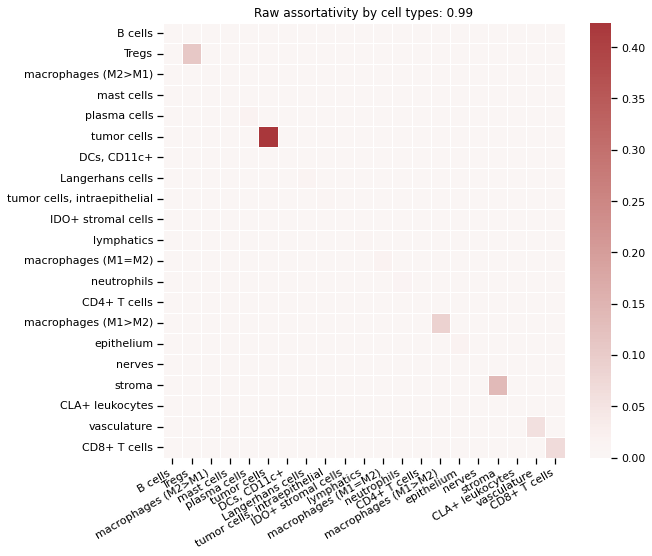

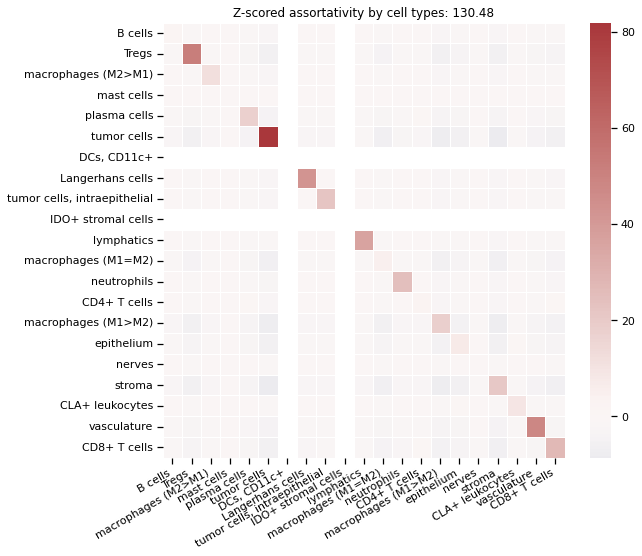

In [84]:
# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_raw, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right', fontsize=20);
# plt.yticks(fontsize=20);
# plt.savefig(save_dir / "assortativity", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.savefig(save_dir / "assortativity_z-scored", bbox_inches='tight', facecolor='white')

Raw assortativity by cell types: 0.99
Z-scored assortativity by cell types: 130.48


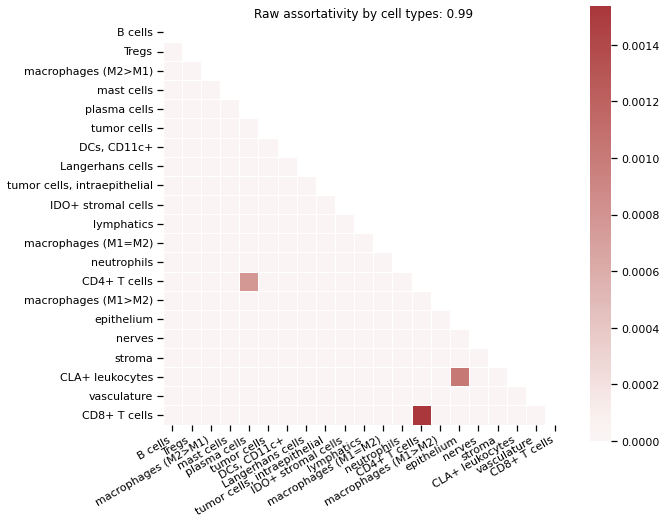

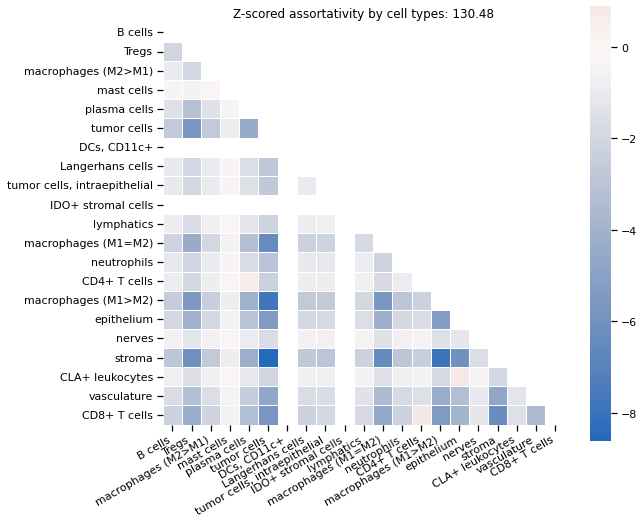

In [85]:
# Hide diagonal
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(mixmat_raw, dtype=bool))

# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_raw, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right', fontsize=20);
# plt.yticks(fontsize=20);
# plt.savefig(save_dir / "assortativity", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.savefig(save_dir / "assortativity_z-scored", bbox_inches='tight', facecolor='white')

After removing highly self-assortative cell-types, we can notice that most cell types tend to avoid other cell types in this sample.

#### Assortativity and patients response

In [33]:
z_cols = [x for x in net_stats.columns if x.endswith('Z')]
z_net_stats = net_stats[z_cols]

In [34]:
# Have a look at nan values
for name, value in z_net_stats.isna().sum().iteritems():
    print(name, ' ' * (52- len(name)), value)

assort Z                                              0
B cells - B cells Z                                   22
CD4+ T cells - B cells Z                              16
CD4+ T cells - CD4+ T cells Z                         10
CD8+ T cells - B cells Z                              15
CD8+ T cells - CD4+ T cells Z                         7
CD8+ T cells - CD8+ T cells Z                         7
CLA+ leukocytes - B cells Z                           30
CLA+ leukocytes - CD4+ T cells Z                      23
CLA+ leukocytes - CD8+ T cells Z                      23
CLA+ leukocytes - CLA+ leukocytes Z                   30
DCs, CD11c+ - B cells Z                               54
DCs, CD11c+ - CD4+ T cells Z                          53
DCs, CD11c+ - CD8+ T cells Z                          53
DCs, CD11c+ - CLA+ leukocytes Z                       56
DCs, CD11c+ - DCs, CD11c+ Z                           60
epithelium - B cells Z                                15
epithelium - CD4+ T cells Z       

There are some nan values due to interactions between rare cell types that never happened.  
Can can have a first look at the sample, but it would be more informative to have a look at samples before therapy, grouping them per patient.

In [35]:
# we need to clean-up data for further analyses and visualizations
z_net_stats_cleaned, select_finite = mosna.clean_data(
    z_net_stats, 
    method='mixed',
    thresh=0.8,
    )

There are 4598 non finite values
Imputing data


Let's add information about patients' group and time of biopsy

In [36]:
if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
status.sort_values('Spots')

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg003         1       3      3
reg004         1       3      4
reg006         2       1      6
...          ...     ...    ...
reg066        14       4     66
reg067         9       3     67
reg068         9       3     68
reg069        13       3     69
reg070        13       3     70

[68 rows x 3 columns]

In [37]:
# samples 25, 36, 37, 40, 44 are missing
# pd.set_option('display.max_rows', 10)
# reg026 and reg044 not in biopsies
z_net_stats_cleaned = pd.concat([status, z_net_stats_cleaned], axis=1, join='inner').sort_values('Spots')
z_net_stats_cleaned.drop(columns=['Spots'], inplace=True)
z_net_stats_cleaned

Patients  Groups    assort Z  B cells - B cells Z  \
id                                                          
reg001         1       1  130.482109             1.772149   
reg002         1       1  150.960958             3.824806   
reg003         1       3  116.854780            -0.100504   
reg004         1       3   73.205329             5.987776   
reg006         2       1   48.300866             4.903167   
...          ...     ...         ...                  ...   
reg066        14       4   83.973483             6.695244   
reg067         9       3  230.776570            26.097372   
reg068         9       3  200.974654            14.551642   
reg069        13       3  124.291239            13.915476   
reg070        13       3   64.403963            13.217289   

        CD4+ T cells - B cells Z  CD4+ T cells - CD4+ T cells Z  \
id                                                                
reg001                 -0.961295                       3.235127   
reg002                 -0.619942                      11.487365   
reg003                 -0.336670                      10.237502   
reg004                 -0.330326                       2.369958   
reg006                 -0.175863                      -0.077693   
...                          ...                            ...   
reg066                 -0.100504                       8.351821   
reg067                 -3.464738                      17.412634   
reg068                 -1.712544                      16.218512   
reg069                 -1.048871                      -0.181818   
reg070                 -0.240002                      -0.100504   

        CD8+ T cells - B cells Z  CD8+ T cells - CD4+ T cells Z  \
id                                                                
reg001                 -2.236463                       0.889436   
reg002                 -1.221076                       2.045769   
reg003                 -0.854043                      -1.986434   
reg004                 -0.587085                      -1.252791   
reg006                 -0.248135                      -0.171106   
...                          ...                            ...   
reg066                 -0.229416                      -0.319438   
reg067                 -3.806717                     -10.418082   
reg068                 -2.883217                      -6.622706   
reg069                 -1.781405                      -0.905585   
reg070                 -0.292346                      -0.171106   

        CD8+ T cells - CD8+ T cells Z  CLA+ leukocytes - B cells Z  ...  \
id                                                                  ...   
reg001                      27.052366                    -0.802060  ...   
reg002                      21.967946                    -0.307148  ...   
reg003                      13.596103                    -0.142857  ...   
reg004                      12.729408                    -0.215012  ...   
reg006                      -0.181818                    -0.177131  ...   
...                               ...                          ...  ...   
reg066                      14.422209                    -0.100504  ...   
reg067                      44.579649                    -0.423283  ...   
reg068                      48.408308                    -0.296217  ...   
reg069                      52.633243                    -0.387409  ...   
reg070                      -0.063372                    -0.218083  ...   

        vasculature - macrophages (M2>M1) Z  vasculature - mast cells Z  \
id                                                                        
reg001                            -1.573321                   -0.548763   
reg002                            -2.415007                   -0.816497   
reg003                            -1.473931                   -1.536859   
reg004                            -1.362140                   -0.981304   
reg006                            -2.488803 

In [38]:
pvals = mosna.find_DE_markers(z_net_stats_cleaned.iloc[:, 1:], group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [39]:
pvals.head(20)

pval  pval_corr
Langerhans cells - B cells Z               0.002314   0.159410
vasculature - CD4+ T cells Z               0.003436   0.159410
tumor cells - B cells Z                    0.003436   0.159410
IDO+ stromal cells - IDO+ stromal cells Z  0.003436   0.159410
CD4+ T cells - B cells Z                   0.003436   0.159410
mast cells - B cells Z                     0.006330   0.183559
macrophages (M1=M2) - lymphatics Z         0.006330   0.183559
tumor cells - CD4+ T cells Z               0.006330   0.183559
tumor cells - lymphatics Z                 0.009129   0.211804
tumor cells - macrophages (M1>M2) Z        0.009129   0.211804
tumor cells - macrophages (M1=M2) Z        0.012649   0.220660
macrophages (M1>M2) - B cells Z            0.012649   0.220660
vasculature - B cells Z                    0.012649   0.220660
CD8+ T cells - B cells Z                   0.016169   0.220660
macrophages (M2>M1) - B cells Z            0.016169   0.220660
stroma - B cells Z                         0.016169   0.220660
CLA+ leukocytes - CLA+ leukocytes Z        0.016169   0.220660
DCs, CD11c+ - DCs, CD11c+ Z                0.020433   0.263364
lymphatics - CD4+ T cells Z                0.024278   0.281623
assort Z                                   0.024278   0.281623

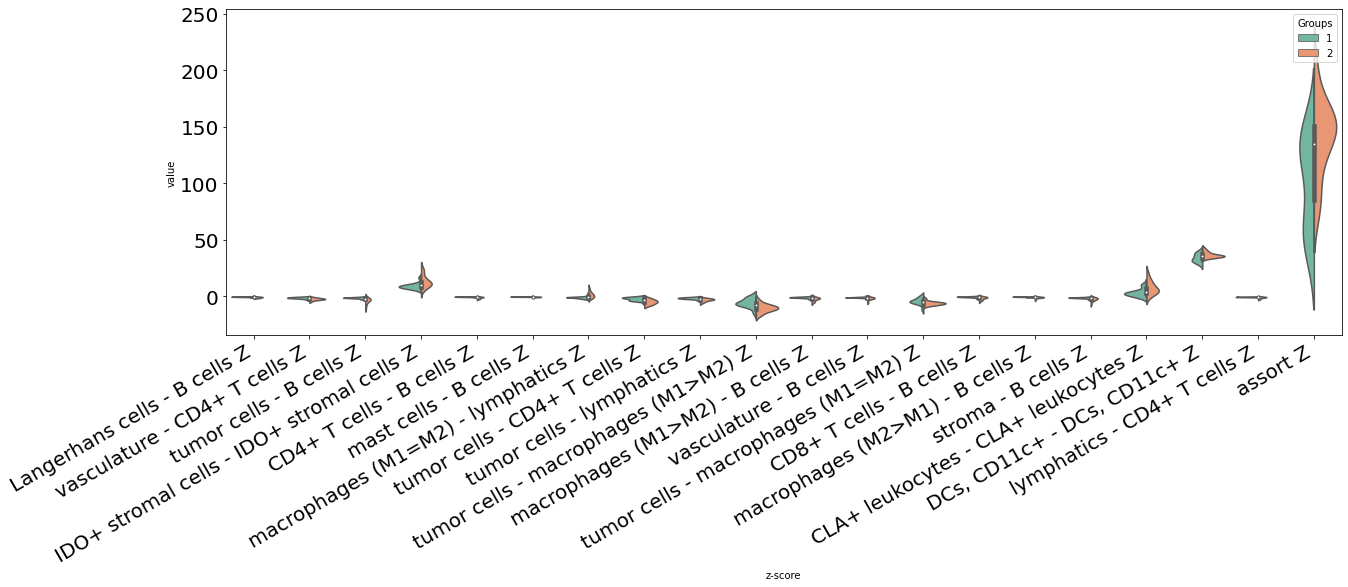

In [40]:
reload(mosna)
fig, ax = mosna.plot_distrib_groups(
    z_net_stats_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

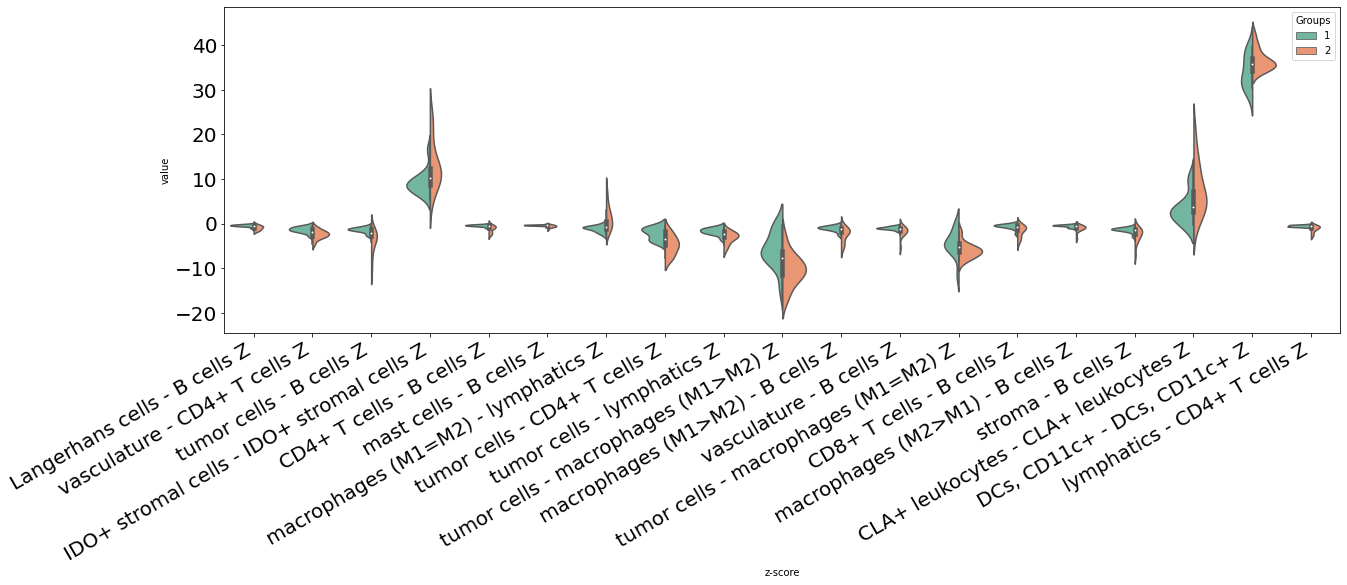

In [41]:
exclude_vars = [
    'assort Z',
]
fig, ax = mosna.plot_distrib_groups(
    z_net_stats_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    exclude_vars=exclude_vars,
    )

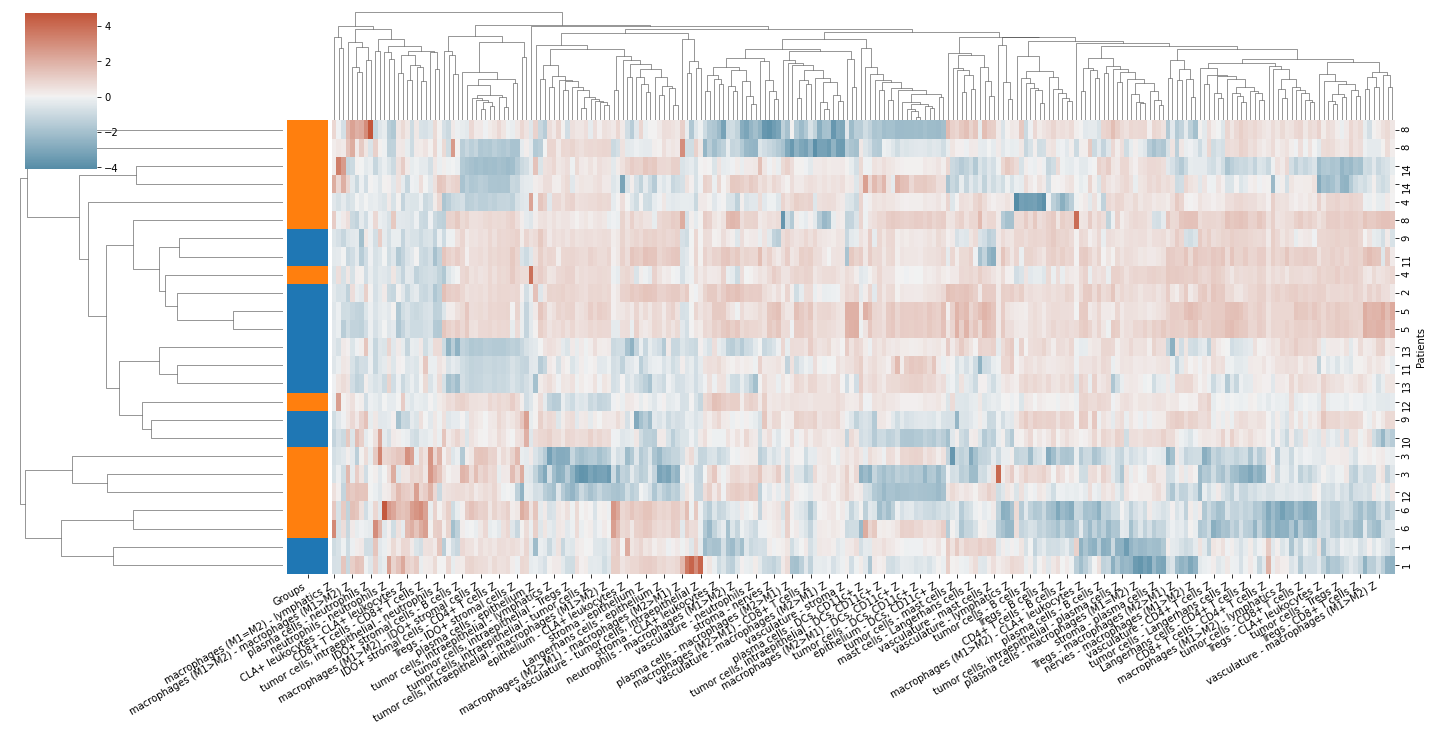

In [42]:
mosna.plot_heatmap(
    z_net_stats_cleaned, 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    skip_cols=['assort Z'],
    )

Samples are a bit clustered into consistent response groups, but it's not incredible.  
We also need to aggregate samples per patient and time of biopsy, that may help us correcting nan values and have more variables, and hopefully better clusters.

#### Samples aggregation per patient and time point.

In [43]:
z_net_stats = pd.concat([status, z_net_stats], axis=1, join='inner').sort_values('Spots')
z_net_stats.drop(columns=['Spots'], inplace=True)

In [44]:
# good news: the mean of aggregated data already ignores nans
z_net_stats_agg = z_net_stats.groupby(['Patients', 'Groups']).mean()
z_net_stats_agg

assort Z  B cells - B cells Z  CD4+ T cells - B cells Z  \
Patients Groups                                                              
1        1       140.721534             2.798477                 -0.790618   
         3        95.030054            -0.100504                 -0.336670   
2        1        48.300866             4.903167                 -0.175863   
         3       165.484763            10.547484                 -1.092646   
3        2       177.789734            -0.063372                 -0.769316   
         4       177.419725                  NaN                       NaN   
4        2       107.205784            66.074287                 -1.351651   
         4       149.398316            16.285710                 -0.636327   
5        1        59.900707                  NaN                       NaN   
         3        53.274925                  NaN                 -0.089803   
6        2       162.853051            11.281211                 -2.260668   
         4       182.599852            21.189173                  1.392694   
7        2        32.729591                  NaN                       NaN   
         4        50.961678            -0.156813                 -0.183766   
8        2       128.514739             0.802431                 -0.565944   
         4       180.587953            19.152574                  0.065069   
9        1       102.574061                  NaN                 -0.178666   
         3       161.426942            17.261514                 -1.846861   
10       1       136.008464            -0.163383                 -0.377026   
         3       136.103359            -0.089803                 -0.194257   
11       1        76.971797            -0.077693                       NaN   
         3        42.892595            -0.077693                 -0.063372   
12       2       132.449068             1.192723                 -0.800436   
         4       146.929145            -0.291235                  0.046854   
13       1       131.969816            -0.100504                 -0.475412   
         3       121.360681            29.136013                 -2.641673   
14       2       140.225408             3.074550                 -0.742431   
         4       170.302494            17.552198                  2.964220   

                 CD4+ T cells - CD4+ T cells Z  CD8+ T cells - B cells Z  \
Patients Groups                                                            
1        1                            7.361246                 -1.728769   
         3                            6.303730                 -0.854043   
2        1                           -0.077693                 -0.248135   
         3                            2.530072                 -0.935437   
3        2                           28.084873                 -0.743890   
         4                           16.308500                       NaN   
4        2                            6.280882                 -1.820815   
         4                           18.861148                 -1.342023   
5        1                                 NaN                       NaN   
         3                            8.773510                 -0.063372   
6        2                           52.225913                 -3.819893   
         4                           22.262536                 -2.530172   
7        2                                 NaN                       NaN   
         4                                 NaN                 -0.543542   
8        2                            7.275594                 -0.503545   
         4                            9.265321                 -2.312895   
9        1                           11.243569                 -0.298342   
         3                            9.580831                 -2.449506   
10       1                            9.793876                 -0.752495   
         3                            4.358899                 -0.499038   
11    

In [45]:
# Have a look at nan values
for name, value in z_net_stats_agg.isna().sum().iteritems():
    print(name, ' ' * (52- len(name)), value)

assort Z                                              0
B cells - B cells Z                                   5
CD4+ T cells - B cells Z                              4
CD4+ T cells - CD4+ T cells Z                         4
CD8+ T cells - B cells Z                              3
CD8+ T cells - CD4+ T cells Z                         2
CD8+ T cells - CD8+ T cells Z                         2
CLA+ leukocytes - B cells Z                           9
CLA+ leukocytes - CD4+ T cells Z                      8
CLA+ leukocytes - CD8+ T cells Z                      8
CLA+ leukocytes - CLA+ leukocytes Z                   10
DCs, CD11c+ - B cells Z                               22
DCs, CD11c+ - CD4+ T cells Z                          21
DCs, CD11c+ - CD8+ T cells Z                          21
DCs, CD11c+ - CLA+ leukocytes Z                       22
DCs, CD11c+ - DCs, CD11c+ Z                           24
epithelium - B cells Z                                3
epithelium - CD4+ T cells Z               

In [46]:
z_net_agg_cleaned, select_finite = mosna.clean_data(
    z_net_stats_agg, 
    method='mixed',
    thresh=0.8,
    )

There are 1498 non finite values
Imputing data


In [47]:
pvals = mosna.find_DE_markers(z_net_agg_cleaned.iloc[:, 1:], group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [48]:
pvals.head(20)

pval  pval_corr
CD4+ T cells - B cells Z                            0.008159   0.628205
tumor cells - macrophages (M1>M2) Z                 0.008159   0.628205
tumor cells, intraepithelial - IDO+ stromal cel...  0.008159   0.628205
tumor cells - lymphatics Z                          0.015152   0.680225
tumor cells - CD4+ T cells Z                        0.015152   0.680225
lymphatics - lymphatics Z                           0.038462   0.680225
macrophages (M1>M2) - lymphatics Z                  0.038462   0.680225
macrophages (M1>M2) - B cells Z                     0.038462   0.680225
tumor cells - CD8+ T cells Z                        0.038462   0.680225
CLA+ leukocytes - CD8+ T cells Z                    0.038462   0.680225
CD8+ T cells - B cells Z                            0.038462   0.680225
tumor cells, intraepithelial - B cells Z            0.067599   0.680225
Langerhans cells - B cells Z                        0.067599   0.680225
IDO+ stromal cells - IDO+ stromal cells Z           0.067599   0.680225
stroma - B cells Z                                  0.067599   0.680225
Tregs - Tregs Z                                     0.067599   0.680225
macrophages (M2>M1) - CD8+ T cells Z                0.067599   0.680225
tumor cells - B cells Z                             0.067599   0.680225
lymphatics - CLA+ leukocytes Z                      0.067599   0.680225
vasculature - lymphatics Z                          0.067599   0.680225

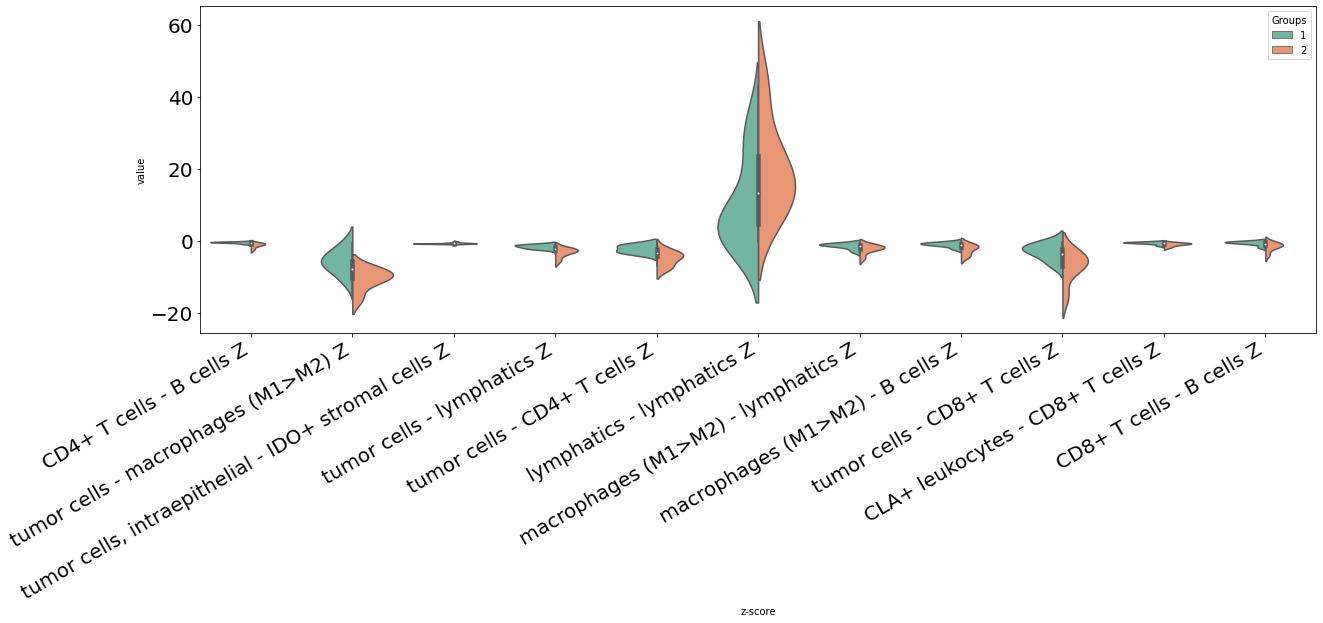

In [49]:
fig, ax = mosna.plot_distrib_groups(
    z_net_agg_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    )

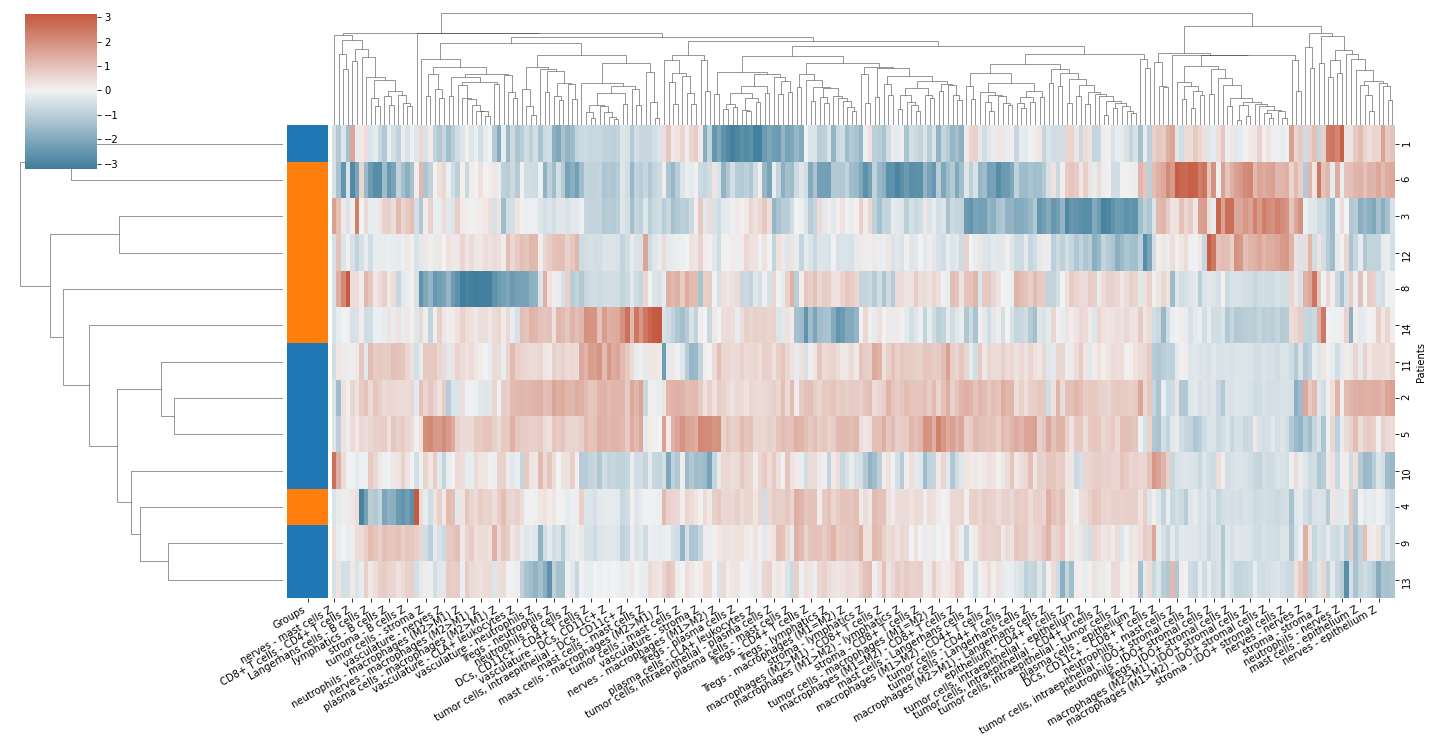

In [52]:
mosna.plot_heatmap(
    z_net_agg_cleaned.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    )

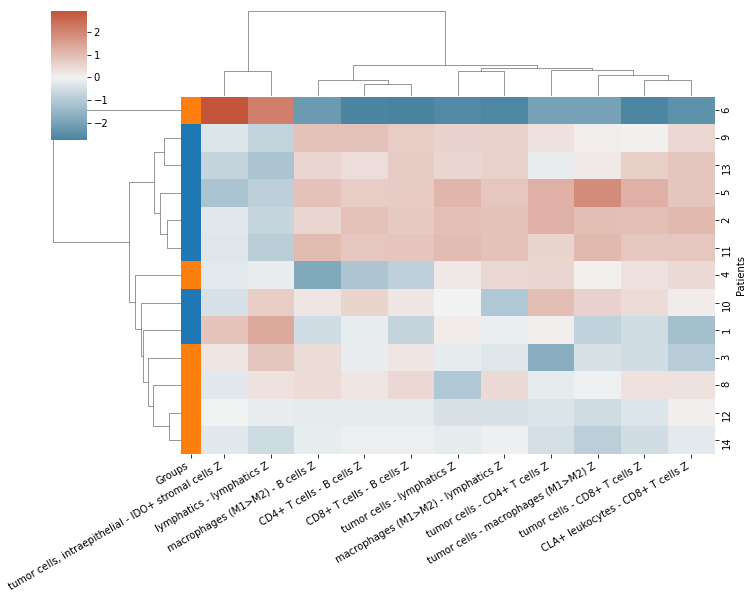

In [51]:
# use the most statistically relevant variable separating groups
# Note: that's to have a clue, do not use this method for real,
# it's a tautology!

nb_vars = np.sum(pvals['pval'] <= 0.05)
nb_vars = min(nb_vars, 20)
marker_vars = pvals.sort_values(by='pval', ascending=True).head(nb_vars).index.tolist()

mosna.plot_heatmap(
    z_net_agg_cleaned[marker_vars].reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    )

### Marker-positive cells interactions

We can also compute the mixing matrix and assortativity between marker-positive cells.

## Cellular neighborhoods

The mixing matrix and assortativity give us information about the global network organization.  
Here we will see how to use the *Neighbors Aggregation Statistics* method to find local "cellular communities", or "neighborhoods", or "niches", that can be relevant to understand disease progression or response to therapies.  

In [91]:
processed_dir = Path('../data/processed/CODEX_CTCL')
load_dir = processed_dir / "all_samples_networks"
save_dir = processed_dir / "nas"    
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [86]:
# aggregate neighbooring cell types
markers = cell_type_cols
attrib_all = obj[cell_type_cols]
X = attrib_all.values
edges_all = pd.read_csv(load_dir / 'sample_all-edges.csv')
pairs = edges_all.values

### First order neighbors, mean and std

In [88]:
order = 1
var_type = 'markers'
var_aggreg = mosna.aggregate_k_neighbors(
    X=X,
    pairs=pairs,
    order=order,
    var_names=markers,
)

In [113]:
var_aggreg.to_csv(save_dir / f'nas_on-{var_type}_samples-all_stat-mean-std_order-{order}.csv', index=False)

In [ ]:
# Uncomment to load already computed NAS
var_aggreg = pd.read_csv(save_dir / 'nas_on-{var_type}_samples-all_stat-mean-std.csv')

In [93]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(var_aggreg)
embedding.shape

(117170, 2)

embedding done


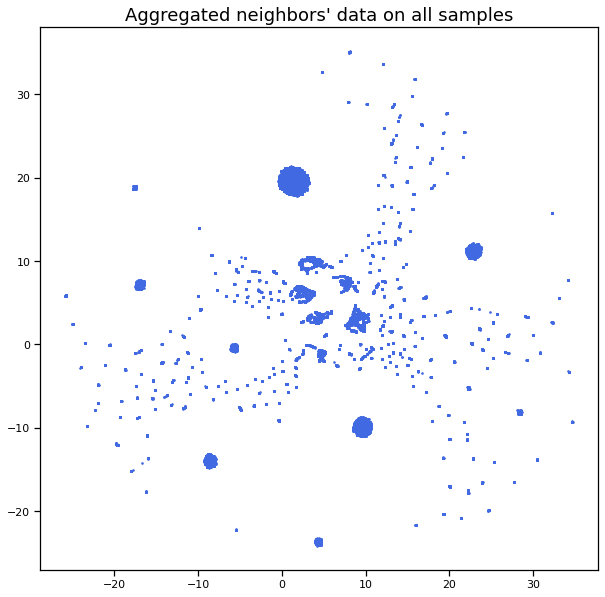

In [122]:
reducer = umap.UMAP(
    n_neighbors=70,
    metric='euclidean',
    min_dist=0.0,
    spread=1.0,
    random_state=0,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    )
embedding = reducer.fit_transform(var_aggreg)
embedding.shape
print('embedding done')

plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = "Aggregated neighbors' data on all samples"
plt.title(title, fontsize=18);

In [94]:
title = f"umap_on-{var_type}_sample-all_nas-mean-std_order-{order}_dim_clust-2"
np.savetxt(str(save_dir / title) + '.csv',
           embedding, 
           fmt='%.18e', delimiter=',', newline='\n')
title = "reducer-" + title
joblib.dump(reducer, str(save_dir / title) + '.pkl')

['../data/processed/CODEX_CTCL/nas/reducer-umap_sample-all_nas-mean-std_order-1_dim_clust-2.pkl']

#### UMAP viz

In [95]:
# For the visualization
marker = '.'
size_points = 10

In [ ]:
# Uncomment to load already computed embedding and reducer
title = f"umap_sample-all_nas-mean-std_order-{order}_dim_clust-2"
embedding = np.loadtxt(str(save_dir / title) + '.csv', delimiter=',')
title = "reducer-" + title
reducer = joblib.load(str(save_dir / title) + '.pkl')

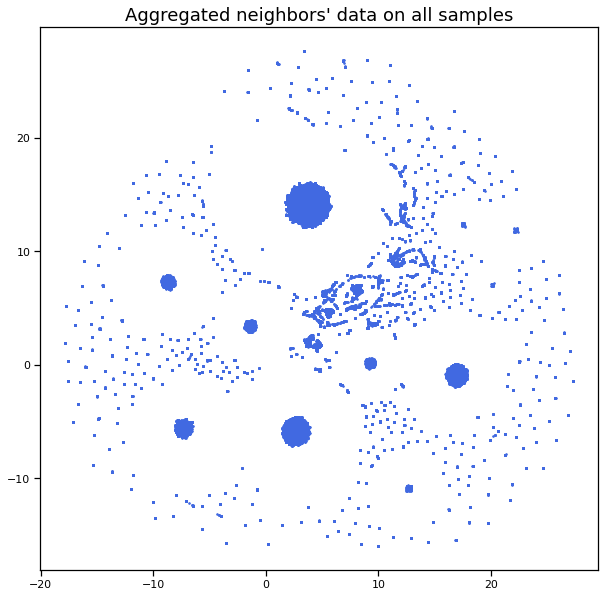

In [96]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = "Aggregated neighbors' data on all samples"
plt.title(title, fontsize=18);
# plt.savefig('../data/processed/'+title, bbox_inches='tight')

In [192]:
# TODO: interactive visualization with Holoviews, Datashader and Bokeh

#### Screen NAS parameters

In [ ]:
reload(mosna)

orders = [1]
dim_clusts = [2, 3, 4, 5, 6, 7, 8, 9]
min_cluster_sizes = [100, 250, 500, 750, 1000]
parallel_dim = False
parallel_clustering = 12
processed_dir = Path('../data/processed/CODEX_CTCL')
opt_str = '_samples-all_stat-mean-std'

mosna.screen_nas_parameters(X, pairs, markers, orders, dim_clusts, min_cluster_sizes, processed_dir, soft_clustering=True, 
                            opt_str=opt_str, parallel_dim=parallel_dim, parallel_clustering=parallel_clustering, memory_limit='100GB')


#### Make good colormap

In [140]:
attrib_all

B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  DCs, CD11c+  \
0             1             0             0                0            0   
1             1             0             0                0            0   
2             1             0             0                0            0   
3             1             0             0                0            0   
4             1             0             0                0            0   
...         ...           ...           ...              ...          ...   
117165        0             0             0                0            0   
117166        0             0             0                0            0   
117167        0             0             0                0            0   
117168        0             0             0                0            0   
117169        0             0             0                0            0   

        IDO+ stromal cells  Langerhans cells  Tregs  epithelium  lymphatics  \
0                        0                 0      0           0           0   
1                        0                 0      0           0           0   
2                        0                 0      0           0           0   
3                        0                 0      0           0           0   
4                        0                 0      0           0           0   
...                    ...               ...    ...         ...         ...   
117165                   0                 0      0           0           0   
117166                   0                 0      0           0           0   
117167                   0                 0      0           0           0   
117168                   0                 0      0           0           0   
117169                   0                 0      0           0           0   

        ...  macrophages (M1>M2)  macrophages (M2>M1)  mast cells  nerves  \
0       ...                    0                    0           0       0   
1       ...                    0                    0           0       0   
2       ...                    0                    0           0       0   
3       ...                    0                    0           0       0   
4       ...                    0                    0           0       0   
...     ...                  ...                  ...         ...     ...   
117165  ...                    0                    0           0       0   
117166  ...                    0                    0           0       0   
117167  ...                    0                    0           0       0   
117168  ...                    0                    0           0       0   
117169  ...                    0                    0           0       0   

        neutrophils  plasma cells  stroma  tumor cells  \
0                 0             0       0            0   
1                 0             0       0            0   
2                 0             0       0            0   
3                 0             0       0            0   
4                 0             0       0            0   
...             ...           ...     ...          ...   
117165            0             0       0            0   
117166            0             0       0            0   
117167            0             0       0            0   
117168            0             0       0            0   
117169            0             0       0            0   

        tumor cells, intraepithelial  vasculature  
0                                  0            0  
1                                  0            0  
2                                  0            0  
3                                  0            0  
4                                  0            0  
...                              ...          ...  
117165                             0            1  
117166                             0            1  
117167                             0        

In [141]:
# mapper_attrib = attrib_all['Group'].value_counts()
mapper_attrib = attrib_all.sum()
mapper_attrib

B cells                          2205
CD4+ T cells                     1647
CD8+ T cells                     5350
CLA+ leukocytes                   218
DCs, CD11c+                       211
IDO+ stromal cells                237
Langerhans cells                 1744
Tregs                            7733
epithelium                      18182
lymphatics                        783
macrophages (M1=M2)              4426
macrophages (M1>M2)             13800
macrophages (M2>M1)              1859
mast cells                        619
nerves                            572
neutrophils                       430
plasma cells                      725
stroma                          11210
tumor cells                     38499
tumor cells, intraepithelial     1316
vasculature                      5404
dtype: int64

#### Clusters visualization

In [ ]:
reload(mosna)

orders = [1]
dim_clusts = [2, 3, 4, 5, 6, 7, 8, 9]
min_cluster_sizes = [100, 250, 500, 750, 1000]
processed_dir = Path('../data/processed/CODEX_CTCL')
opt_str = '_samples-all_stat-mean-std'

mosna.plot_screened_parameters(obj, cell_pos_cols, cell_type_cols, orders, dim_clusts, processed_dir,
                               min_cluster_sizes, all_edges='all_samples_networks', sampling=False, var_type=None, 
                               downsample=False, aggreg_dir=None, load_dir=None, save_dir=None, opt_str=opt_str)

### Data tranformation

In [ ]:
import composition_stats as cs

In [ ]:
processed_dir = Path('../data/processed/CODEX_CTCL')
load_dir = processed_dir / "all_samples_networks"
save_dir = processed_dir / "nas_on_markers"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

markers = marker_cols
attrib_all = obj[marker_cols]
X = attrib_all.values
edges_all = pd.read_csv(load_dir / 'sample_all-edges.csv')
pairs = edges_all.values

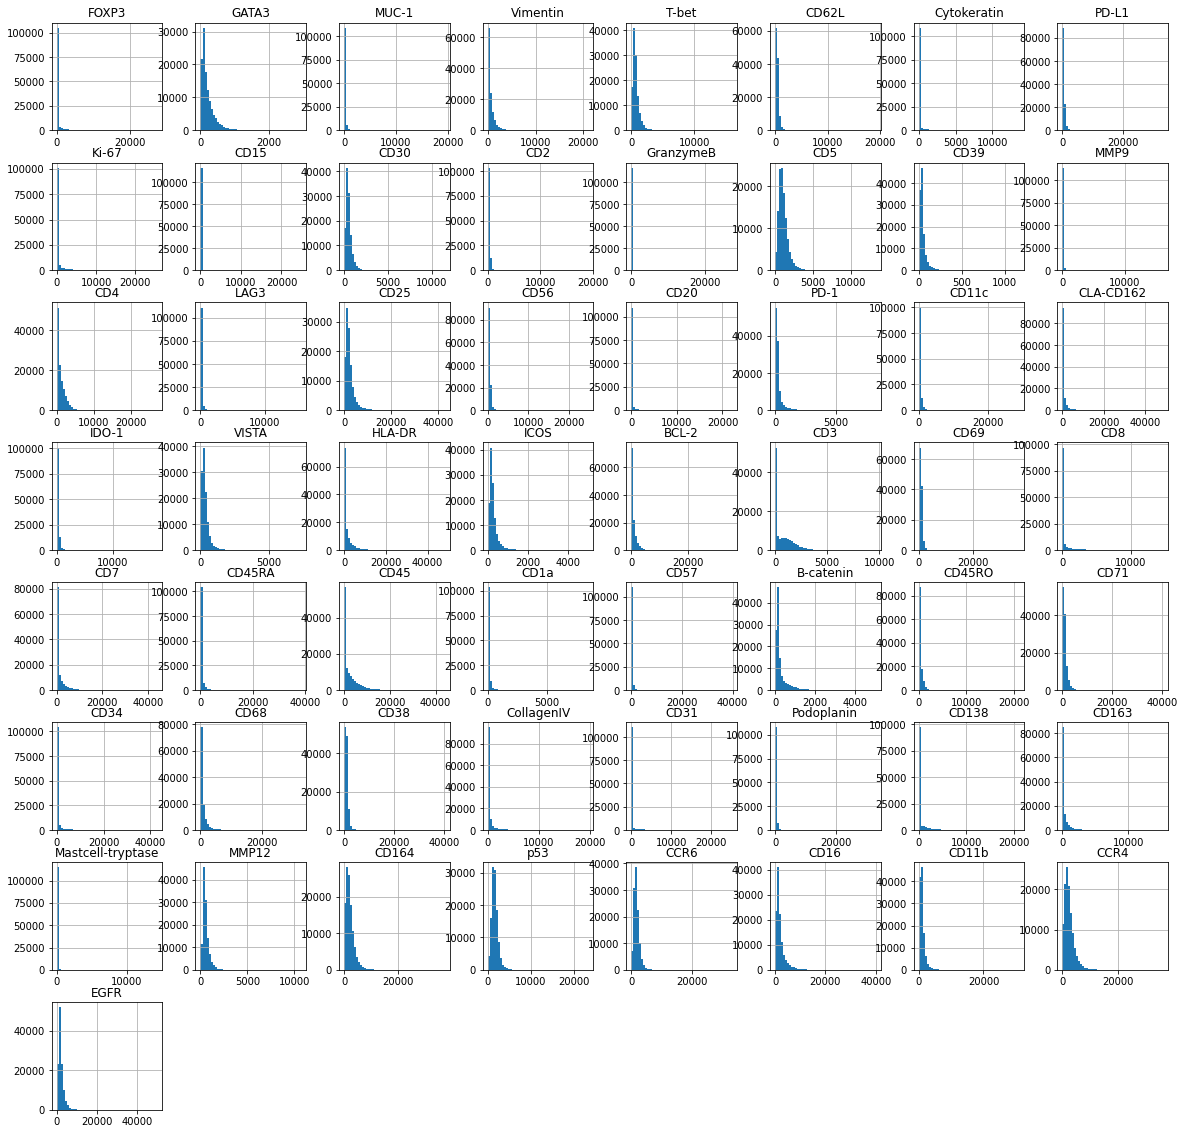

In [ ]:
attrib_all.hist(bins=50, figsize=(20, 20));

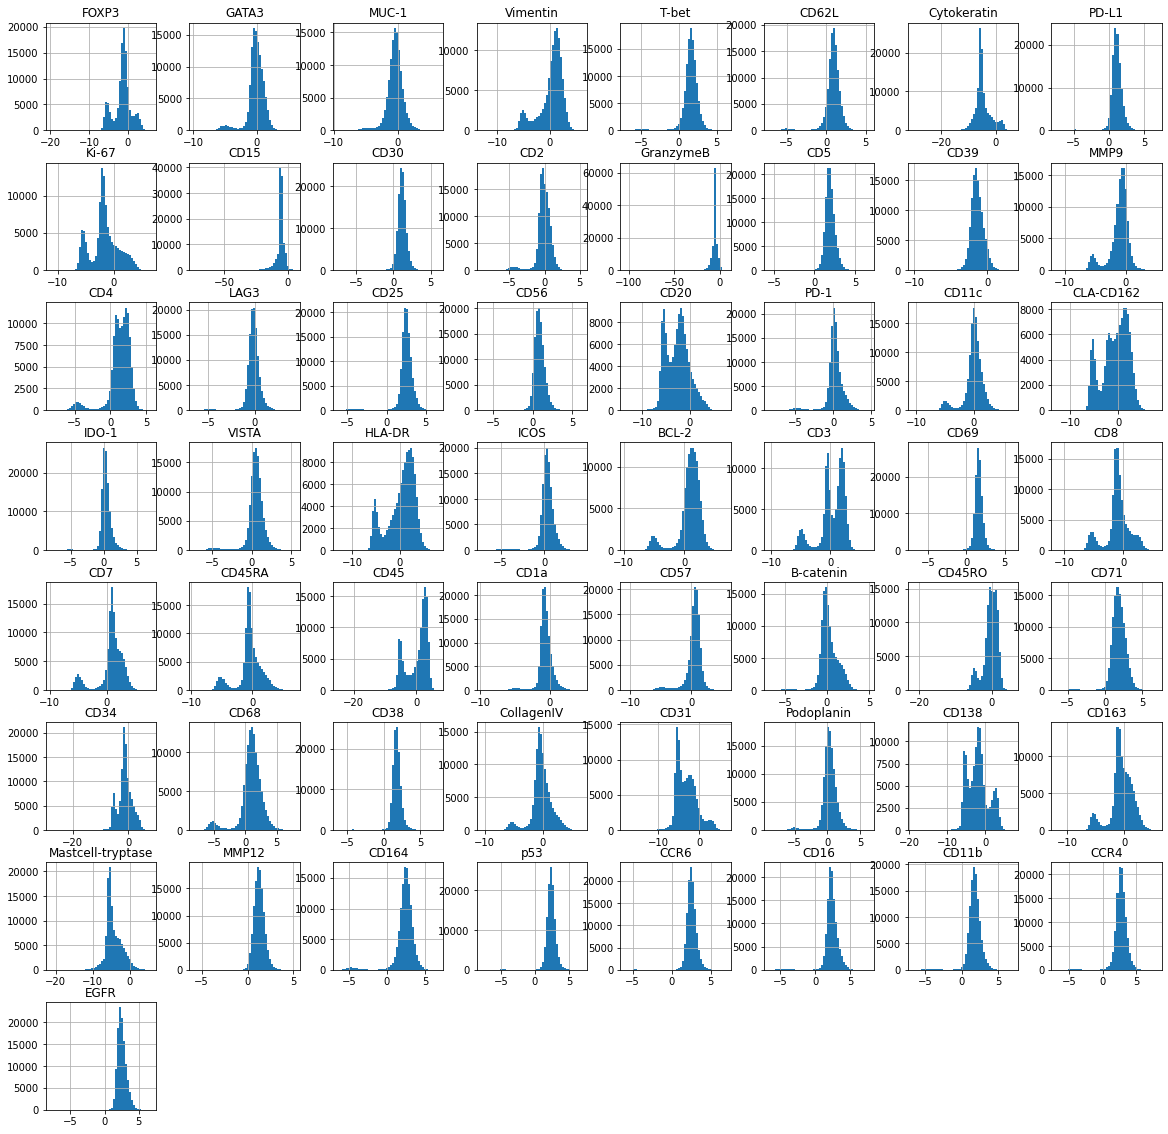

In [ ]:
X = attrib_all.values
X[X == 0] = X.max() / 100000

X_clr = cs.clr(cs.closure(X))
attrib_all_clr = attrib_all.copy()
attrib_all_clr.loc[:, :] = X_clr
attrib_all_clr.hist(bins=50, figsize=(20, 20));

In [ ]:
order = 1
var_type = 'markers'

In [ ]:
var_aggreg = mosna.aggregate_k_neighbors(
    X=X_clr,
    pairs=pairs,
    order=order,
    var_names=marker_cols,
)

In [ ]:
var_aggreg.to_csv(save_dir / f'nas_on-{var_type}_samples-all_stat-mean-std_order-{order}.csv', index=False)

In [ ]:
# Uncomment to load already computed NAS
var_aggreg = pd.read_csv(save_dir / 'nas_on-{var_type}_samples-all_stat-mean-std.csv')

In [ ]:
reducer = umap.UMAP(random_state=0)
embedding = reducer.fit_transform(var_aggreg)
embedding.shape

(117170, 2)

In [ ]:
# For the visualization
marker = '.'
size_points = 10

embedding done


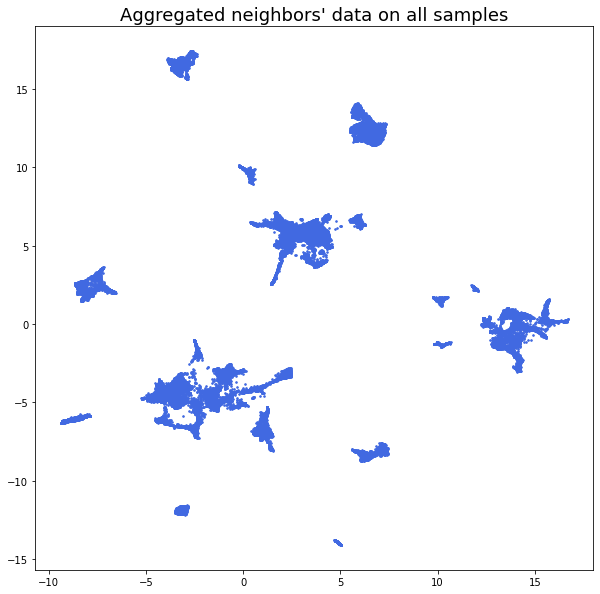

In [ ]:
reducer = umap.UMAP(
    n_neighbors=70,
    metric='euclidean',
    min_dist=0.0,
    spread=1.0,
    random_state=0,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    )
embedding = reducer.fit_transform(var_aggreg)
embedding.shape
print('embedding done')

plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = "Aggregated neighbors' data on all samples"
plt.title(title, fontsize=18);